# Tiền Xử Lý và Chuẩn Hóa Dữ Liệu COCOMO II (Phiên bản nâng cao)

Notebook này thực hiện việc tiền xử lý và chuẩn hóa dữ liệu từ nhiều nguồn khác nhau để phục vụ cho việc xây dựng mô hình ước lượng nỗ lực phát triển phần mềm theo mô hình COCOMO II.

## Mục tiêu

- Thu thập và tổ chức dữ liệu từ nhiều nguồn khác nhau (CSV, ARFF)
- Phân loại dữ liệu theo 3 schema: LOC, FP, và UCP
- Tiền xử lý và chuẩn hóa dữ liệu (xử lý missing values, outliers)
- Biến đổi dữ liệu để chuẩn bị cho việc xây dựng mô hình học máy
- Xuất dữ liệu đã xử lý thành các file CSV riêng biệt

**Người thực hiện:** Huy-VNNIC  
**Ngày thực hiện:** 30/06/2025

## 1. Import Các Thư Viện Cần Thiết

Đầu tiên, chúng ta cần import các thư viện Python cần thiết cho việc xử lý dữ liệu, phân tích thống kê, và trực quan hóa.

In [1]:
# Import các thư viện cơ bản
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import glob
import warnings
from scipy import stats
from pathlib import Path
import json
from datetime import datetime

# Thư viện cho xử lý dữ liệu
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)  # Hiển thị tất cả các cột
pd.set_option('display.max_rows', 100)      # Hiển thị tối đa 100 dòng
pd.set_option('display.width', 1000)        # Độ rộng của output
pd.set_option('display.float_format', '{:.4f}'.format)  # Format số thập phân

# Bỏ qua cảnh báo để output gọn gàng hơn
warnings.filterwarnings('ignore')

# Cấu hình biểu đồ
plt.style.use('ggplot')
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
COLORS = ["#2196f3", "#4caf50", "#ff9800", "#f44336", "#9c27b0"]

# Cấu hình đầu ra
%matplotlib inline

print("Các thư viện đã được import thành công!")

Các thư viện đã được import thành công!


## 2. Thiết Lập Đường Dẫn và Khám Phá Dữ Liệu

Trong phần này, chúng ta sẽ thiết lập các đường dẫn đến thư mục dữ liệu và khám phá cấu trúc thư mục để hiểu rõ hơn về dữ liệu sẵn có.

In [2]:
# Thiết lập các đường dẫn
BASE_DIR = Path('/home/huy/Huy-workspace/AI-Project')
DATASETS_DIR = BASE_DIR / 'datasets'  # Thư mục chứa dữ liệu
SOFTWARE_DATASETS_DIR = BASE_DIR / 'Software-estimation-datasets'  # Thư mục dữ liệu phần mềm bổ sung
OUTPUT_DIR = BASE_DIR / 'processed_data'  # Thư mục đầu ra

# Tạo thư mục output nếu chưa tồn tại
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"Đã tạo thư mục output: {OUTPUT_DIR}")
else:
    print(f"Thư mục output đã tồn tại: {OUTPUT_DIR}")

# Liệt kê các thư mục con trong thư mục datasets
print("\nCấu trúc thư mục datasets:")
for root, dirs, _ in os.walk(DATASETS_DIR):
    # Hiển thị tối đa 3 cấp thư mục
    level = root.replace(str(DATASETS_DIR), '').count(os.sep)
    if level <= 2:
        indent = '  ' * level
        print(f"{indent}└── {os.path.basename(root)}/")

# Liệt kê các thư mục con trong thư mục Software-estimation-datasets
print("\nCấu trúc thư mục Software-estimation-datasets:")
if os.path.exists(SOFTWARE_DATASETS_DIR):
    for item in os.listdir(SOFTWARE_DATASETS_DIR):
        item_path = os.path.join(SOFTWARE_DATASETS_DIR, item)
        if os.path.isdir(item_path):
            print(f"  └── {item}/")
        else:
            print(f"  └── {item}")
else:
    print("Thư mục Software-estimation-datasets không tồn tại!")

Thư mục output đã tồn tại: /home/huy/Huy-workspace/AI-Project/processed_data

Cấu trúc thư mục datasets:
└── datasets/
  └── timeSeries/
  └── sna/
  └── other/
  └── effortEstimation/
  └── defectPred/
    └── ssbse14Data/
    └── BPD/
    └── OO/
    └── D1/
    └── eclipse/
    └── hadoop/
    └── ck/
    └── unified/
    └── BugCatchers/
    └── nasa/
  └── textMining/

Cấu trúc thư mục Software-estimation-datasets:
  └── Subbiah.csv
  └── Desharnais.csv
  └── Valdes-Souto.csv
  └── finnish.arff
  └── kitchenham.arff
  └── .git/
  └── albrecht.arff
  └── maxwell.arff
  └── .gitattributes
  └── renzo-pomodoro.csv
  └── UCP_Dataset.csv
  └── Huijgens492.zip
  └── COCOMO-81.csv
  └── china.arff
  └── miyazaki94.arff
  └── Project-22/
  └── nasa93.arff
  └── README.MD
  └── CESAW.tgz
  └── SiP/


In [3]:
# Tìm tất cả các file CSV và ARFF trong các thư mục dữ liệu
def find_files_by_extension(directory, extensions):
    """
    Tìm tất cả các file có phần mở rộng được chỉ định trong thư mục
    
    Args:
        directory: Thư mục cần tìm kiếm
        extensions: Danh sách các phần mở rộng file (ví dụ: ['.csv', '.arff'])
        
    Returns:
        Danh sách đường dẫn đến các file tìm thấy
    """
    files = []
    if os.path.exists(directory):
        for root, _, filenames in os.walk(directory):
            for filename in filenames:
                if any(filename.lower().endswith(ext) for ext in extensions):
                    files.append(os.path.join(root, filename))
    return files

# Tìm các file CSV và ARFF
csv_files = find_files_by_extension(DATASETS_DIR, ['.csv'])
arff_files = find_files_by_extension(DATASETS_DIR, ['.arff'])

software_csv_files = find_files_by_extension(SOFTWARE_DATASETS_DIR, ['.csv']) 
software_arff_files = find_files_by_extension(SOFTWARE_DATASETS_DIR, ['.arff'])

# Hiển thị số lượng file tìm thấy
print(f"\nTìm thấy {len(csv_files)} file CSV trong thư mục datasets.")
print(f"Tìm thấy {len(arff_files)} file ARFF trong thư mục datasets.")
print(f"Tìm thấy {len(software_csv_files)} file CSV trong thư mục Software-estimation-datasets.")
print(f"Tìm thấy {len(software_arff_files)} file ARFF trong thư mục Software-estimation-datasets.")

# Hiển thị một số file CSV đầu tiên để có cái nhìn tổng quan
def display_sample_files(files, limit=5, title="Danh sách một số file"):
    print(f"\n{title} ({min(limit, len(files))} / {len(files)}):")
    for i, file in enumerate(files[:limit]):
        print(f"  {i+1}. {os.path.basename(file)}")
    if len(files) > limit:
        print("  ...")

display_sample_files(csv_files, title="Danh sách một số file CSV từ datasets")
display_sample_files(arff_files, title="Danh sách một số file ARFF từ datasets")
display_sample_files(software_csv_files, title="Danh sách một số file CSV từ Software-estimation-datasets")
display_sample_files(software_arff_files, title="Danh sách một số file ARFF từ Software-estimation-datasets")


Tìm thấy 105 file CSV trong thư mục datasets.
Tìm thấy 75 file ARFF trong thư mục datasets.
Tìm thấy 11 file CSV trong thư mục Software-estimation-datasets.
Tìm thấy 7 file ARFF trong thư mục Software-estimation-datasets.

Danh sách một số file CSV từ datasets (5 / 105):
  1. data_countries.csv
  2. followers.csv
  3. DataBikeSharing.csv
  4. flights.csv
  5. data_countries.csv
  ...

Danh sách một số file ARFF từ datasets (5 / 75):
  1. cocomonasa_v1.arff
  2. finnish.arff
  3. albretch.arff
  4. kitchenham.arff
  5. chinaOriginal.arff
  ...

Danh sách một số file CSV từ Software-estimation-datasets (5 / 11):
  1. Subbiah.csv
  2. Desharnais.csv
  3. Valdes-Souto.csv
  4. renzo-pomodoro.csv
  5. UCP_Dataset.csv
  ...

Danh sách một số file ARFF từ Software-estimation-datasets (5 / 7):
  1. finnish.arff
  2. kitchenham.arff
  3. albrecht.arff
  4. maxwell.arff
  5. china.arff
  ...


## 3. Đọc và Phân Tích Dữ Liệu

Để xử lý các file dữ liệu từ nhiều định dạng khác nhau (CSV, ARFF), chúng ta cần viết các hàm tiện ích để đọc và phân tích dữ liệu. Sau đó, chúng ta sẽ khám phá một số file dữ liệu tiềm năng để xác định những file nào phù hợp cho từng schema (LOC, FP, UCP).

In [6]:
# Hàm đọc file ARFF
def read_arff_file(file_path):
    """
    Đọc file ARFF và chuyển thành DataFrame
    
    Args:
        file_path: Đường dẫn đến file ARFF
        
    Returns:
        DataFrame đã được đọc từ file ARFF
    """
    try:
        with open(file_path, 'r') as f:
            content = f.readlines()
        
        # Tìm vị trí bắt đầu của dữ liệu (sau @data)
        data_start = 0
        attributes = []
        attribute_types = {}
        
        for i, line in enumerate(content):
            line = line.strip().lower()
            if line.startswith('@attribute'):
                # Trích xuất tên thuộc tính
                parts = re.findall(r'@attribute\s+[\'"]?([^\'"]+)[\'"]?\s+(.+)', line)
                if parts:
                    attr_name, attr_type = parts[0]
                    attributes.append(attr_name.strip())
                    attribute_types[attr_name.strip()] = attr_type.strip()
            elif line.startswith('@data'):
                data_start = i + 1
                break
        
        # Đọc dữ liệu từ vị trí @data
        data_rows = []
        for i in range(data_start, len(content)):
            line = content[i].strip()
            if line and not line.startswith('%'):  # Bỏ qua comment và dòng trống
                values = line.split(',')
                if len(values) == len(attributes):
                    data_rows.append(values)
        
        # Tạo DataFrame
        df = pd.DataFrame(data_rows, columns=attributes)
        
        # Chuyển đổi kiểu dữ liệu
        for col in df.columns:
            if attribute_types.get(col, '').lower() in ['numeric', 'real', 'integer']:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        return df
    except Exception as e:
        print(f"Lỗi khi đọc file ARFF {file_path}: {str(e)}")
        return None

In [5]:
# Hàm đọc file CSV
def read_csv_file(file_path):
    """
    Đọc file CSV và chuyển thành DataFrame
    
    Args:
        file_path: Đường dẫn đến file CSV
        
    Returns:
        DataFrame đã được đọc từ file CSV
    """
    try:
        # Thử đọc với dấu phẩy làm delimiter
        df = pd.read_csv(file_path)
        
        # Kiểm tra nếu chỉ có 1 cột, có thể file sử dụng delimiter khác
        if len(df.columns) == 1:
            # Thử với dấu chấm phẩy
            df = pd.read_csv(file_path, sep=';')
            
            # Thử với dấu tab
            if len(df.columns) == 1:
                df = pd.read_csv(file_path, sep='\t')
                
        return df
    except Exception as e:
        print(f"Lỗi khi đọc file CSV {file_path}: {str(e)}")
        return None

# Hàm khám phá cấu trúc dữ liệu
def explore_dataframe(df, filename=""):
    """
    Khám phá và hiển thị thông tin cơ bản về DataFrame
    
    Args:
        df: DataFrame cần khám phá
        filename: Tên file (để hiển thị)
        
    Returns:
        None
    """
    if df is None or df.empty:
        print(f"DataFrame rỗng hoặc không tồn tại!")
        return
    
    print(f"\n{'='*80}")
    print(f"File: {filename}")
    print(f"{'='*80}")
    
    print(f"Shape: {df.shape[0]} dòng × {df.shape[1]} cột")
    
    print("\nCác cột:")
    for col in df.columns:
        print(f"  - {col} ({df[col].dtype})")
    
    # Hiển thị mẫu dữ liệu
    print("\nMẫu dữ liệu:")
    print(df.head(3))
    
    # Kiểm tra giá trị null
    null_counts = df.isnull().sum()
    if null_counts.sum() > 0:
        print("\nSố lượng giá trị null:")
        for col, count in null_counts[null_counts > 0].items():
            print(f"  - {col}: {count} ({count/len(df):.2%})")
    
    # Hiển thị thống kê mô tả cho các cột số
    numeric_cols = df.select_dtypes(include=['number']).columns
    if len(numeric_cols) > 0:
        print("\nThống kê mô tả cho các cột số:")
        print(df[numeric_cols].describe().round(2).T)

# Khám phá một số file tiềm năng cho từng schema
def identify_schema(df):
    """
    Xác định schema dựa trên các cột trong DataFrame
    
    Args:
        df: DataFrame cần xác định schema
        
    Returns:
        Danh sách các schema được xác định: ['loc', 'fp', 'ucp']
    """
    schemas = []
    
    # Các từ khóa liên quan đến LOC
    loc_keywords = ['loc', 'kloc', 'sloc', 'loc_', 'line', 'code']
    # Các từ khóa liên quan đến FP
    fp_keywords = ['fp', 'function_point', 'function point', 'functionpoint']
    # Các từ khóa liên quan đến UCP
    ucp_keywords = ['ucp', 'use_case', 'use case', 'usecase']
    
    # Kiểm tra các cột có chứa từ khóa không
    for col in df.columns:
        col_lower = col.lower()
        
        # Kiểm tra LOC
        if any(keyword in col_lower for keyword in loc_keywords):
            schemas.append('loc')
            break
    
    for col in df.columns:
        col_lower = col.lower()
        
        # Kiểm tra FP
        if any(keyword in col_lower for keyword in fp_keywords):
            schemas.append('fp')
            break
    
    for col in df.columns:
        col_lower = col.lower()
        
        # Kiểm tra UCP
        if any(keyword in col_lower for keyword in ucp_keywords):
            schemas.append('ucp')
            break
    
    return schemas

In [7]:
# Khám phá các file dữ liệu tiềm năng cho từng schema

# Danh sách các file tiềm năng có thể chứa dữ liệu LOC
loc_potential_files = [
    # File từ dataset ant
    os.path.join(DATASETS_DIR, 'defectPred/ck/ant/ant-1.7/ant-1.7.csv'),
    os.path.join(DATASETS_DIR, 'defectPred/ck/ant/ant-1.6/ant-1.6.csv'),
    os.path.join(DATASETS_DIR, 'defectPred/ck/ant/ant-1.5/ant-1.5.csv'),
    os.path.join(DATASETS_DIR, 'defectPred/ck/ant/ant-1.4/ant-1.4.csv'),
    os.path.join(DATASETS_DIR, 'defectPred/ck/ant/ant-1.3/ant-1.3.csv'),
    
    # File từ dataset BugCatchers
    os.path.join(DATASETS_DIR, 'defectPred/BugCatchers/Apache.csv'),
    os.path.join(DATASETS_DIR, 'defectPred/BugCatchers/ArgoUML.csv'),
    os.path.join(DATASETS_DIR, 'defectPred/BugCatchers/Eclipse.csv'),
    
    # File từ dataset OO
    os.path.join(DATASETS_DIR, 'defectPred/OO/ant-1.7.arff'),
    os.path.join(DATASETS_DIR, 'defectPred/OO/camel-1.6.arff'),
    os.path.join(DATASETS_DIR, 'defectPred/OO/ivy-2.0.arff'),
    
    # File từ dataset NASA
    os.path.join(DATASETS_DIR, 'defectPred/nasa/D\'/CM1.arff'),
    os.path.join(DATASETS_DIR, 'defectPred/nasa/D\'/KC1.arff')
]

# Danh sách các file tiềm năng có thể chứa dữ liệu FP
fp_potential_files = [
    # File albrecht chứa dữ liệu Function Points
    os.path.join(SOFTWARE_DATASETS_DIR, 'albrecht.arff'),
    
    # File Subbiah chứa TotalUFP (Function Points)
    os.path.join(SOFTWARE_DATASETS_DIR, 'Subbiah.csv')
]

# Danh sách các file tiềm năng có thể chứa dữ liệu UCP
ucp_potential_files = [
    # File UCP_Dataset chứa dữ liệu Use Case Points
    os.path.join(SOFTWARE_DATASETS_DIR, 'UCP_Dataset.csv')
]

# Khám phá dữ liệu từ các file tiềm năng
# Tạo dictionary để lưu trữ DataFrame đã đọc
dataframes = {
    'loc': [],
    'fp': [],
    'ucp': []
}

# Khám phá các file LOC
print("\nKhám phá các file tiềm năng cho schema LOC:")
for file_path in loc_potential_files:
    if not os.path.exists(file_path):
        print(f"File không tồn tại: {file_path}")
        continue
    
    if file_path.endswith('.csv'):
        df = read_csv_file(file_path)
    elif file_path.endswith('.arff'):
        df = read_arff_file(file_path)
    else:
        print(f"Định dạng file không được hỗ trợ: {file_path}")
        continue
    
    if df is not None:
        schemas = identify_schema(df)
        if 'loc' in schemas:
            print(f"File {os.path.basename(file_path)} phù hợp với schema LOC")
            df['source'] = os.path.basename(file_path)
            dataframes['loc'].append(df)
        else:
            print(f"File {os.path.basename(file_path)} KHÔNG phù hợp với schema LOC")

# Khám phá các file FP
print("\nKhám phá các file tiềm năng cho schema FP:")
for file_path in fp_potential_files:
    if not os.path.exists(file_path):
        print(f"File không tồn tại: {file_path}")
        continue
    
    if file_path.endswith('.csv'):
        df = read_csv_file(file_path)
    elif file_path.endswith('.arff'):
        df = read_arff_file(file_path)
    else:
        print(f"Định dạng file không được hỗ trợ: {file_path}")
        continue
    
    if df is not None:
        explore_dataframe(df, os.path.basename(file_path))
        schemas = identify_schema(df)
        if 'fp' in schemas:
            print(f"File {os.path.basename(file_path)} phù hợp với schema FP")
            df['source'] = os.path.basename(file_path)
            dataframes['fp'].append(df)
        else:
            # Kiểm tra thủ công cho các file FP đặc biệt
            if 'TotalUFP' in df.columns or 'output' in df.columns:
                print(f"File {os.path.basename(file_path)} phù hợp với schema FP (xác định thủ công)")
                df['source'] = os.path.basename(file_path)
                dataframes['fp'].append(df)
            else:
                print(f"File {os.path.basename(file_path)} KHÔNG phù hợp với schema FP")

# Khám phá các file UCP
print("\nKhám phá các file tiềm năng cho schema UCP:")
for file_path in ucp_potential_files:
    if not os.path.exists(file_path):
        print(f"File không tồn tại: {file_path}")
        continue
    
    if file_path.endswith('.csv'):
        df = read_csv_file(file_path)
    elif file_path.endswith('.arff'):
        df = read_arff_file(file_path)
    else:
        print(f"Định dạng file không được hỗ trợ: {file_path}")
        continue
    
    if df is not None:
        explore_dataframe(df, os.path.basename(file_path))
        schemas = identify_schema(df)
        if 'ucp' in schemas:
            print(f"File {os.path.basename(file_path)} phù hợp với schema UCP")
            df['source'] = os.path.basename(file_path)
            dataframes['ucp'].append(df)
        else:
            # Kiểm tra thủ công cho các file UCP đặc biệt
            if 'UAW' in df.columns or 'UUCW' in df.columns or 'Simple Actors' in df.columns:
                print(f"File {os.path.basename(file_path)} phù hợp với schema UCP (xác định thủ công)")
                df['source'] = os.path.basename(file_path)
                dataframes['ucp'].append(df)
            else:
                print(f"File {os.path.basename(file_path)} KHÔNG phù hợp với schema UCP")

# Hiển thị tổng số dữ liệu đã phân loại
print(f"\nTổng số dữ liệu đã phân loại:")
print(f"  - LOC: {len(dataframes['loc'])} file")
print(f"  - FP: {len(dataframes['fp'])} file")
print(f"  - UCP: {len(dataframes['ucp'])} file")


Khám phá các file tiềm năng cho schema LOC:
File ant-1.7.csv phù hợp với schema LOC
File ant-1.6.csv phù hợp với schema LOC
File ant-1.5.csv phù hợp với schema LOC
File ant-1.4.csv phù hợp với schema LOC
File ant-1.3.csv phù hợp với schema LOC
File Apache.csv phù hợp với schema LOC
File ArgoUML.csv phù hợp với schema LOC
File Eclipse.csv phù hợp với schema LOC
File ant-1.7.arff phù hợp với schema LOC
File camel-1.6.arff phù hợp với schema LOC
File ivy-2.0.arff phù hợp với schema LOC
File CM1.arff phù hợp với schema LOC
File KC1.arff phù hợp với schema LOC

Khám phá các file tiềm năng cho schema FP:

File: albrecht.arff
Shape: 24 dòng × 8 cột

Các cột:
  - input (int64)
  - output (int64)
  - inquiry (int64)
  - file (int64)
  - fpadj (float64)
  - rawfpcounts (float64)
  - adjfp (int64)
  - effort (float64)

Mẫu dữ liệu:
   input  output  inquiry  file  fpadj  rawfpcounts  adjfp   effort
0     25     150       75    60 1.0000    1750.0000   1750 102.4000
1    193      98       70    3

## 4. Chuẩn Hóa và Xử Lý Dữ Liệu Schema LOC

Sau khi đã phân loại dữ liệu, chúng ta sẽ bắt đầu với việc chuẩn hóa và xử lý dữ liệu cho schema LOC (Lines of Code). Quá trình này bao gồm:

1. Trích xuất thông tin LOC từ các file dữ liệu
2. Chuẩn hóa LOC thành KLOC (nghìn dòng code)
3. Ước tính effort, time, và developers dựa trên LOC và bug
4. Xử lý missing values và outliers
5. Biến đổi dữ liệu (log transform)

In [10]:
# Hàm chuẩn hóa dữ liệu LOC
def normalize_loc_data(df, source):
    """
    Chuẩn hóa dữ liệu từ các nguồn khác nhau thành định dạng thống nhất cho schema LOC
    
    Args:
        df: DataFrame gốc
        source: Tên nguồn dữ liệu
        
    Returns:
        DataFrame đã chuẩn hóa với các cột: kloc, effort_pm, time_months, developers
    """
    normalized_df = pd.DataFrame()
    
    # Copy source
    normalized_df['source'] = df['source']
    
    # Xử lý dữ liệu theo từng nguồn
    if 'ant-' in source:
        # LOC: Chuyển về KLOC
        if 'loc' in df.columns:
            normalized_df['kloc'] = df['loc'] / 1000
        else:
            # Ước tính LOC từ wmc (weighted methods per class) và amc (average method complexity)
            if 'wmc' in df.columns and 'amc' in df.columns:
                normalized_df['kloc'] = df['wmc'] * df['amc'] / 1000
            else:
                # Fallback: dùng thông số khác hoặc giá trị mặc định
                normalized_df['kloc'] = 1.0  # Giá trị mặc định
            
        # Effort: Sử dụng bug count làm proxy cho effort, giả định 1 bug = 2 người-ngày = 0.1 người-tháng
        if 'bug' in df.columns:
            normalized_df['effort_pm'] = df['bug'] * 0.1
        else:
            # Fallback: ước tính từ kloc
            normalized_df['effort_pm'] = normalized_df['kloc'] * 0.5
        
        # Time: Ước tính từ loc và bug (heuristic: 1000 LOC with bugs cần 0.5 tháng để fix)
        if 'loc' in df.columns and 'bug' in df.columns:
            loc_value = df['loc']
            normalized_df['time_months'] = (loc_value * df['bug'] / 1000 * 0.5).clip(lower=0.1)
        else:
            # Fallback: ước tính từ kloc
            normalized_df['time_months'] = normalized_df['kloc'] * 0.3
        
        # Developers: Ước tính từ kích thước dự án (heuristic: 50 KLOC = 5 developers)
        normalized_df['developers'] = np.ceil(normalized_df['kloc'] / 10).clip(lower=1)
        
    elif source in ['Apache.csv', 'ArgoUML.csv', 'Eclipse.csv']:
        # LOC: Lấy từ cột codeLines hoặc code
        if 'codeLines' in df.columns:
            normalized_df['kloc'] = df['codeLines'] / 1000
        elif 'code' in df.columns:
            normalized_df['kloc'] = df['code'] / 1000
        else:
            # Fallback
            normalized_df['kloc'] = 1.0
            
        # Effort: Sử dụng NumberFaults làm proxy, giả định 1 lỗi = 0.1 người-tháng
        if 'NumberFaults' in df.columns:
            normalized_df['effort_pm'] = df['NumberFaults'] * 0.1
        else:
            # Nếu không có NumberFaults, ước tính dựa trên LOC
            normalized_df['effort_pm'] = normalized_df['kloc'] * 0.5
            
        # Time: Ước tính từ kloc (heuristic)
        normalized_df['time_months'] = normalized_df['kloc'] * 0.3
        
        # Developers: Ước tính
        normalized_df['developers'] = np.ceil(normalized_df['kloc'] / 10).clip(lower=1)
    
    elif 'arff' in source:
        # LOC: Lấy từ các cột khác nhau tùy theo file
        if 'loc' in df.columns:
            normalized_df['kloc'] = df['loc'] / 1000
        elif 'LOC' in df.columns:
            normalized_df['kloc'] = df['LOC'] / 1000
        elif 'LOC_TOTAL' in df.columns:
            normalized_df['kloc'] = df['LOC_TOTAL'] / 1000
        else:
            # Không tìm thấy cột LOC phù hợp
            print(f"Không tìm thấy cột LOC trong file {source}. Cột hiện có: {', '.join(df.columns)}")
            return pd.DataFrame()  # Trả về DataFrame rỗng
        
        # Effort: Ước tính từ bug nếu có, hoặc từ độ phức tạp
        if 'bug' in df.columns:
            normalized_df['effort_pm'] = df['bug'] * 0.1
        elif 'bugs' in df.columns:
            normalized_df['effort_pm'] = df['bugs'] * 0.1
        else:
            # Ước tính effort từ kloc
            normalized_df['effort_pm'] = normalized_df['kloc'] * 0.5
        
        # Time: Ước tính từ kloc
        normalized_df['time_months'] = normalized_df['kloc'] * 0.3
        
        # Developers: Ước tính
        normalized_df['developers'] = np.ceil(normalized_df['kloc'] / 10).clip(lower=1)
    
    else:
        # Không thuộc các nguồn đã biết, thử xác định dựa vào tên cột
        
        # Cố gắng tìm cột liên quan đến LOC
        loc_found = False
        for col in df.columns:
            col_lower = col.lower()
            if 'loc' in col_lower or 'line' in col_lower or 'code' in col_lower:
                normalized_df['kloc'] = df[col] / 1000
                loc_found = True
                break
                
        if not loc_found:
            print(f"Không tìm thấy cột LOC trong file {source}. Cột hiện có: {', '.join(df.columns)}")
            return pd.DataFrame()  # Trả về DataFrame rỗng
            
        # Ước tính effort, time, developers từ kloc
        normalized_df['effort_pm'] = normalized_df['kloc'] * 0.5
        normalized_df['time_months'] = normalized_df['kloc'] * 0.3
        normalized_df['developers'] = np.ceil(normalized_df['kloc'] / 10).clip(lower=1)
    
    # Loại bỏ các hàng có giá trị null hoặc âm ở các cột quan trọng
    for col in ['kloc', 'effort_pm', 'time_months', 'developers']:
        normalized_df = normalized_df[(normalized_df[col].notna()) & (normalized_df[col] > 0)]
    
    # Làm tròn các giá trị số để dễ đọc
    normalized_df['kloc'] = normalized_df['kloc'].round(4)
    normalized_df['effort_pm'] = normalized_df['effort_pm'].round(2)
    normalized_df['time_months'] = normalized_df['time_months'].round(2)
    normalized_df['developers'] = normalized_df['developers'].astype(int)
    
    return normalized_df

# Áp dụng chuẩn hóa cho từng DataFrame LOC
loc_normalized_dfs = []

if dataframes['loc']:
    for df in dataframes['loc']:
        source = df['source'].iloc[0]
        normalized_df = normalize_loc_data(df, source)
        if not normalized_df.empty:
            loc_normalized_dfs.append(normalized_df)
            print(f"Đã chuẩn hóa dữ liệu {source}: {normalized_df.shape[0]} dòng")

# Kết hợp tất cả các DataFrame đã chuẩn hóa
if loc_normalized_dfs:
    loc_combined_df = pd.concat(loc_normalized_dfs, ignore_index=True)
    print(f"\nTổng số dữ liệu LOC sau khi chuẩn hóa: {loc_combined_df.shape[0]} dòng × {loc_combined_df.shape[1]} cột")
    
    # Hiển thị mẫu dữ liệu
    print("\nMẫu dữ liệu LOC sau khi chuẩn hóa:")
    print(loc_combined_df.sample(5))
else:
    print("Không có dữ liệu LOC nào được chuẩn hóa thành công!")
    loc_combined_df = pd.DataFrame()

Đã chuẩn hóa dữ liệu ant-1.7.csv: 166 dòng
Đã chuẩn hóa dữ liệu ant-1.6.csv: 92 dòng
Đã chuẩn hóa dữ liệu ant-1.5.csv: 32 dòng
Đã chuẩn hóa dữ liệu ant-1.4.csv: 40 dòng
Đã chuẩn hóa dữ liệu ant-1.3.csv: 20 dòng
Đã chuẩn hóa dữ liệu Apache.csv: 84 dòng
Đã chuẩn hóa dữ liệu ArgoUML.csv: 195 dòng
Đã chuẩn hóa dữ liệu Eclipse.csv: 318 dòng
Đã chuẩn hóa dữ liệu ant-1.7.arff: 166 dòng
Đã chuẩn hóa dữ liệu camel-1.6.arff: 188 dòng
Đã chuẩn hóa dữ liệu ivy-2.0.arff: 40 dòng
Không tìm thấy cột LOC trong file CM1.arff. Cột hiện có: loc_total, cyclomatic_complexity, essential_complexity, design_complexity, halstead_length, halstead_volume, halstead_level, halstead_difficulty, halstead_content, halstead_effort, b, halstead_prog_time, loc_executable, loc_comments, loc_blank, num_unique_operators, num_unique_operands, num_operators, num_operands, branch_count, defects, source
Không tìm thấy cột LOC trong file KC1.arff. Cột hiện có: loc_total, cyclomatic_complexity, essential_complexity, design_compl

In [11]:
# Xử lý missing values và outliers trong dữ liệu LOC

# Kiểm tra missing values
if not loc_combined_df.empty:
    print("Kiểm tra missing values trong dữ liệu LOC:")
    missing_counts = loc_combined_df.isnull().sum()
    print(missing_counts[missing_counts > 0] if missing_counts.sum() > 0 else "Không có missing values")
    
    # Xử lý missing values (đã thực hiện trong bước chuẩn hóa, nhưng kiểm tra lại)
    loc_clean_df = loc_combined_df.dropna()
    
    # Phát hiện và xử lý outliers bằng phương pháp IQR (Interquartile Range)
    print("\nPhát hiện outliers trong dữ liệu LOC bằng phương pháp IQR:")
    
    loc_clean_df_outliers = loc_clean_df.copy()
    outliers_summary = {}
    
    for column in ['kloc', 'effort_pm', 'time_months', 'developers']:
        # Tính IQR
        Q1 = loc_clean_df[column].quantile(0.25)
        Q3 = loc_clean_df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Xác định ngưỡng để phát hiện outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Đếm số lượng outliers
        outliers_count = ((loc_clean_df[column] < lower_bound) | 
                          (loc_clean_df[column] > upper_bound)).sum()
        
        outliers_summary[column] = {
            'outliers_count': outliers_count,
            'percentage': outliers_count / len(loc_clean_df) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'min': loc_clean_df[column].min(),
            'max': loc_clean_df[column].max()
        }
        
        # In thông tin outliers
        print(f"\nCột '{column}':")
        print(f"- Số lượng outliers: {outliers_count} ({outliers_count/len(loc_clean_df):.2%})")
        print(f"- Ngưỡng: [{lower_bound:.4f}, {upper_bound:.4f}]")
        print(f"- Phạm vi thực tế: [{loc_clean_df[column].min():.4f}, {loc_clean_df[column].max():.4f}]")
        
        # Cắt giới hạn outliers (capping)
        loc_clean_df_outliers[column] = loc_clean_df_outliers[column].clip(lower=lower_bound, upper=upper_bound)
    
    # Tóm tắt sau khi xử lý outliers
    print("\nSau khi xử lý outliers trong dữ liệu LOC:")
    for column in ['kloc', 'effort_pm', 'time_months', 'developers']:
        print(f"- Phạm vi cột '{column}': [{loc_clean_df_outliers[column].min():.4f}, {loc_clean_df_outliers[column].max():.4f}]")
    
    # Thống kê mô tả sau khi xử lý
    print("\nThống kê mô tả dữ liệu LOC sau khi xử lý:")
    print(loc_clean_df_outliers.describe().round(4))
    
    # Hiển thị mẫu dữ liệu sau khi xử lý
    print("\nMẫu dữ liệu LOC sau khi xử lý outliers:")
    print(loc_clean_df_outliers.sample(5))
    
else:
    print("Không có dữ liệu LOC để xử lý!")
    loc_clean_df_outliers = pd.DataFrame()

Kiểm tra missing values trong dữ liệu LOC:
Không có missing values

Phát hiện outliers trong dữ liệu LOC bằng phương pháp IQR:

Cột 'kloc':
- Số lượng outliers: 88 (6.56%)
- Ngưỡng: [-0.5790, 1.0850]
- Phạm vi thực tế: [0.0010, 4.5410]

Cột 'effort_pm':
- Số lượng outliers: 152 (11.33%)
- Ngưỡng: [-0.0500, 0.3500]
- Phạm vi thực tế: [0.1000, 2.8000]

Cột 'time_months':
- Số lượng outliers: 168 (12.53%)
- Ngưỡng: [-0.3200, 0.5600]
- Phạm vi thực tế: [0.0000, 13.6200]

Cột 'developers':
- Số lượng outliers: 0 (0.00%)
- Ngưỡng: [1.0000, 1.0000]
- Phạm vi thực tế: [1.0000, 1.0000]

Sau khi xử lý outliers trong dữ liệu LOC:
- Phạm vi cột 'kloc': [0.0010, 1.0850]
- Phạm vi cột 'effort_pm': [0.1000, 0.3500]
- Phạm vi cột 'time_months': [0.0000, 0.5600]
- Phạm vi cột 'developers': [1.0000, 1.0000]

Thống kê mô tả dữ liệu LOC sau khi xử lý:
           kloc  effort_pm  time_months  developers
count 1341.0000  1341.0000    1341.0000   1341.0000
mean     0.3021     0.1626       0.1575      1.0000


## 5. Chuẩn Hóa và Xử Lý Dữ Liệu Schema FP (Function Points)

Tiếp theo, chúng ta sẽ tiến hành chuẩn hóa và xử lý dữ liệu cho schema FP (Function Points). Quá trình này bao gồm:

1. Trích xuất thông tin FP từ các file dữ liệu
2. Chuẩn hóa FP và các chỉ số liên quan
3. Ước tính effort, time, và developers dựa trên FP
4. Xử lý missing values và outliers
5. Biến đổi dữ liệu (log transform)

In [18]:
# Khám phá dữ liệu FP
print("Khám phá dữ liệu Function Points:")

# Kiểm tra dữ liệu FP tiềm năng
fp_file_paths = fp_potential_files.copy()

# Đọc và khám phá từng file
for file_path in fp_file_paths:
    if not os.path.exists(file_path):
        print(f"File không tồn tại: {file_path}")
        continue
        
    print(f"\nĐọc file: {os.path.basename(file_path)}")
    
    if file_path.endswith('.csv'):
        df = read_csv_file(file_path)
    elif file_path.endswith('.arff'):
        df = read_arff_file(file_path)
    else:
        print(f"Định dạng file không được hỗ trợ: {file_path}")
        continue
        
    if df is not None and not df.empty:
        # Thêm cột source
        df['source'] = os.path.basename(file_path)
        
        # Hiển thị thông tin
        print(f"Shape: {df.shape}")
        print("Columns:")
        for col in df.columns:
            print(f"  - {col} ({df[col].dtype})")
            
        # Hiển thị một số dòng đầu tiên
        print("\nMẫu dữ liệu:")
        print(df.head(3))
        
        # Phân tích cột liên quan đến FP
        fp_cols = []
        for col in df.columns:
            col_lower = str(col).lower()
            if 'fp' in col_lower or 'function' in col_lower or 'point' in col_lower:
                fp_cols.append(col)
                
        if fp_cols:
            print(f"\nCác cột liên quan đến FP: {', '.join(fp_cols)}")
            for fp_col in fp_cols:
                if pd.api.types.is_numeric_dtype(df[fp_col]):
                    print(f"\nThống kê cho cột {fp_col}:")
                    print(df[fp_col].describe())

Khám phá dữ liệu Function Points:

Đọc file: albrecht.arff
Shape: (24, 9)
Columns:
  - input (int64)
  - output (int64)
  - inquiry (int64)
  - file (int64)
  - fpadj (float64)
  - rawfpcounts (float64)
  - adjfp (int64)
  - effort (float64)
  - source (object)

Mẫu dữ liệu:
   input  output  inquiry  file  fpadj  rawfpcounts  adjfp   effort         source
0     25     150       75    60 1.0000    1750.0000   1750 102.4000  albrecht.arff
1    193      98       70    36 1.0000    1902.0000   1902 105.2000  albrecht.arff
2     70      27        0    12 0.8000     535.0000    428  11.1000  albrecht.arff

Các cột liên quan đến FP: fpadj, rawfpcounts, adjfp

Thống kê cho cột fpadj:
count   24.0000
mean     0.9896
std      0.1351
min      0.7500
25%      0.8875
50%      1.0000
75%      1.1000
max      1.2000
Name: fpadj, dtype: float64

Thống kê cho cột rawfpcounts:
count     24.0000
mean     638.5396
std      452.6535
min      189.5200
25%      347.3975
50%      489.1050
75%      699.4475
m

In [21]:
# Chuẩn hóa dữ liệu FP một cách đơn giản
fp_normalized_data = []

# Xử lý dữ liệu FP từ file albrecht.arff
albrecht_path = os.path.join(SOFTWARE_DATASETS_DIR, 'albrecht.arff')
if os.path.exists(albrecht_path):
    print(f"\nChuẩn hóa dữ liệu từ {os.path.basename(albrecht_path)}:")
    df = read_arff_file(albrecht_path)
    
    if df is not None and not df.empty:
        print(f"Cột trong DataFrame: {', '.join(df.columns)}")
        
        # Chuẩn hóa dữ liệu
        normalized_df = pd.DataFrame()
        normalized_df['source'] = 'albrecht.arff'
        
        # FP: Lấy từ cột AFP hoặc FP
        fp_found = False
        if 'AFP' in df.columns:
            normalized_df['fp'] = pd.to_numeric(df['AFP'], errors='coerce')
            fp_found = True
        elif 'FP' in df.columns:
            normalized_df['fp'] = pd.to_numeric(df['FP'], errors='coerce')
            fp_found = True
            
        # Nếu không tìm thấy cột FP
        if not fp_found:
            print("Không tìm thấy cột AFP hoặc FP, sẽ tìm kiếm các cột tương tự...")
            for col in df.columns:
                if 'fp' in col.lower() or 'function' in col.lower() or 'point' in col.lower():
                    print(f"Sử dụng cột {col} cho FP")
                    normalized_df['fp'] = pd.to_numeric(df[col], errors='coerce')
                    fp_found = True
                    break
                    
        # Nếu vẫn không tìm thấy cột FP
        if not fp_found:
            print("Không thể tìm thấy cột FP phù hợp!")
        else:
            # Effort
            if 'Effort' in df.columns:
                normalized_df['effort_pm'] = pd.to_numeric(df['Effort'], errors='coerce')
            elif 'effort' in df.columns:
                normalized_df['effort_pm'] = pd.to_numeric(df['effort'], errors='coerce')
            else:
                # Ước tính effort từ fp
                normalized_df['effort_pm'] = normalized_df['fp'] * 0.2
            
            # Time
            normalized_df['time_months'] = normalized_df['fp'] * 0.1
            
            # Developers
            normalized_df['developers'] = 1  # Default value
            mask = (normalized_df['effort_pm'].notna()) & (normalized_df['time_months'] > 0)
            if mask.any():
                normalized_df.loc[mask, 'developers'] = np.ceil(normalized_df.loc[mask, 'effort_pm'] / normalized_df.loc[mask, 'time_months'])
            
            # Làm sạch dữ liệu
            for col in ['fp', 'effort_pm', 'time_months', 'developers']:
                normalized_df = normalized_df[(normalized_df[col].notna()) & (normalized_df[col] > 0)]
            
            # Làm tròn
            if not normalized_df.empty:
                normalized_df['fp'] = normalized_df['fp'].astype(float).round(2)
                normalized_df['effort_pm'] = normalized_df['effort_pm'].astype(float).round(2)
                normalized_df['time_months'] = normalized_df['time_months'].astype(float).round(2)
                normalized_df['developers'] = normalized_df['developers'].astype(int)
                
                fp_normalized_data.append(normalized_df)
                print(f"Đã chuẩn hóa {len(normalized_df)} dòng từ albrecht.arff")
                print(normalized_df.head(3))

# Kết hợp tất cả các dữ liệu FP
if fp_normalized_data:
    fp_combined_df = pd.concat(fp_normalized_data, ignore_index=True)
    print(f"\nTổng số dữ liệu FP sau khi chuẩn hóa: {fp_combined_df.shape[0]} dòng × {fp_combined_df.shape[1]} cột")
    
    # Hiển thị mẫu dữ liệu
    print("\nMẫu dữ liệu FP sau khi chuẩn hóa:")
    print(fp_combined_df.head(5))
    
    # Thống kê mô tả
    print("\nThống kê mô tả dữ liệu FP:")
    print(fp_combined_df.describe().round(2))
else:
    print("Không có dữ liệu FP nào được chuẩn hóa thành công!")
    fp_combined_df = pd.DataFrame()


Chuẩn hóa dữ liệu từ albrecht.arff:
Cột trong DataFrame: input, output, inquiry, file, fpadj, rawfpcounts, adjfp, effort
Không tìm thấy cột AFP hoặc FP, sẽ tìm kiếm các cột tương tự...
Sử dụng cột fpadj cho FP
Đã chuẩn hóa 24 dòng từ albrecht.arff
  source     fp  effort_pm  time_months  developers
0    NaN 1.0000   102.4000       0.1000        1024
1    NaN 1.0000   105.2000       0.1000        1052
2    NaN 0.8000    11.1000       0.0800         139

Tổng số dữ liệu FP sau khi chuẩn hóa: 24 dòng × 5 cột

Mẫu dữ liệu FP sau khi chuẩn hóa:
  source     fp  effort_pm  time_months  developers
0    NaN 1.0000   102.4000       0.1000        1024
1    NaN 1.0000   105.2000       0.1000        1052
2    NaN 0.8000    11.1000       0.0800         139
3    NaN 1.1500    21.1000       0.1200         184
4    NaN 0.9000    28.8000       0.0900         320

Thống kê mô tả dữ liệu FP:
           fp  effort_pm  time_months  developers
count 24.0000    24.0000      24.0000     24.0000
mean   0.9900

## 6. Chuẩn Hóa và Xử Lý Dữ Liệu Schema UCP (Use Case Points)

Tiếp theo, chúng ta sẽ tiến hành chuẩn hóa và xử lý dữ liệu cho schema UCP (Use Case Points). Quá trình này bao gồm:

1. Trích xuất thông tin UCP từ các file dữ liệu
2. Chuẩn hóa UCP và các chỉ số liên quan
3. Ước tính effort, time, và developers dựa trên UCP
4. Xử lý missing values và outliers
5. Biến đổi dữ liệu (log transform)

In [22]:
# Khám phá dữ liệu UCP
print("Khám phá dữ liệu Use Case Points:")

# Kiểm tra dữ liệu UCP tiềm năng
ucp_file_paths = ucp_potential_files.copy()

# Đọc và khám phá từng file
for file_path in ucp_file_paths:
    if not os.path.exists(file_path):
        print(f"File không tồn tại: {file_path}")
        continue
        
    print(f"\nĐọc file: {os.path.basename(file_path)}")
    
    if file_path.endswith('.csv'):
        df = read_csv_file(file_path)
    elif file_path.endswith('.arff'):
        df = read_arff_file(file_path)
    else:
        print(f"Định dạng file không được hỗ trợ: {file_path}")
        continue
        
    if df is not None and not df.empty:
        # Thêm cột source
        df['source'] = os.path.basename(file_path)
        
        # Hiển thị thông tin
        print(f"Shape: {df.shape}")
        print("Columns:")
        for col in df.columns:
            print(f"  - {col} ({df[col].dtype})")
            
        # Hiển thị một số dòng đầu tiên
        print("\nMẫu dữ liệu:")
        print(df.head(3))
        
        # Phân tích cột liên quan đến UCP
        ucp_cols = []
        for col in df.columns:
            col_lower = str(col).lower()
            if 'ucp' in col_lower or 'use case' in col_lower or 'usecase' in col_lower or 'actor' in col_lower:
                ucp_cols.append(col)
                
        if ucp_cols:
            print(f"\nCác cột liên quan đến UCP: {', '.join(ucp_cols)}")
            for ucp_col in ucp_cols:
                if pd.api.types.is_numeric_dtype(df[ucp_col]):
                    print(f"\nThống kê cho cột {ucp_col}:")
                    print(df[ucp_col].describe())

Khám phá dữ liệu Use Case Points:

Đọc file: UCP_Dataset.csv
Shape: (71, 19)
Columns:
  - Project_No (int64)
  - Simple Actors (float64)
  - Average Actors (int64)
  - Complex Actors (int64)
  - UAW (int64)
  - Simple UC (int64)
  - Average UC (int64)
  - Complex UC (int64)
  - UUCW (int64)
  - TCF (object)
  - ECF (object)
  - Real_P20 (object)
  - Real_Effort_Person_Hours (int64)
  - Sector (object)
  - Language (object)
  - Methodology (object)
  - ApplicationType (object)
  - DataDonator (object)
  - source (object)

Mẫu dữ liệu:
   Project_No  Simple Actors  Average Actors  Complex Actors  UAW  Simple UC  Average UC  Complex UC  UUCW   TCF   ECF Real_P20  Real_Effort_Person_Hours         Sector Language Methodology       ApplicationType DataDonator           source
0           1         1.0000               1               2    9          6          10          15   355  0,81  0,84    398,5                      7970  Manufacturing     Java         NaN                   NaN        

In [26]:
# Chuẩn hóa dữ liệu UCP
ucp_normalized_data = []

# Xử lý dữ liệu UCP từ file UCP_Dataset.csv
ucp_path = os.path.join(SOFTWARE_DATASETS_DIR, 'UCP_Dataset.csv')
if os.path.exists(ucp_path):
    print(f"\nChuẩn hóa dữ liệu từ {os.path.basename(ucp_path)}:")
    df = read_csv_file(ucp_path)
    
    if df is not None and not df.empty:
        print(f"Cột trong DataFrame: {', '.join(df.columns)}")
        
        # Chuyển đổi các cột số thành numeric
        for col in ['UAW', 'UUCW', 'TCF', 'ECF', 'Real_P20', 'Real_Effort_Person_Hours']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # In thông tin về các cột quan trọng
        for col in ['UAW', 'UUCW', 'TCF', 'ECF', 'Real_P20', 'Real_Effort_Person_Hours']:
            if col in df.columns:
                non_na_count = df[col].notna().sum()
                print(f"Cột {col}: {non_na_count}/{len(df)} giá trị không phải NaN")
                if non_na_count > 0:
                    print(f"  Min: {df[col].min()}, Max: {df[col].max()}, Mean: {df[col].mean()}")
        
        # Chuẩn hóa dữ liệu
        normalized_df = pd.DataFrame()
        normalized_df['source'] = 'UCP_Dataset.csv'
        normalized_df['project_id'] = df['Project_No']
        
        # UCP: Tính từ các thành phần
        # UCP = (UAW + UUCW) * TCF * ECF
        
        # Tính UCP chỉ cho các hàng có đủ dữ liệu
        valid_mask = df['UAW'].notna() & df['UUCW'].notna() & df['TCF'].notna() & df['ECF'].notna()
        
        if valid_mask.any():
            print(f"Có {valid_mask.sum()}/{len(df)} hàng có đủ dữ liệu để tính UCP")
            normalized_df['ucp'] = (df['UAW'] + df['UUCW']) * df['TCF'] * df['ECF']
            
            # Effort
            if 'Real_Effort_Person_Hours' in df.columns:
                # Chuyển giờ thành người-tháng (1 người-tháng = 160 giờ)
                normalized_df['effort_pm'] = df['Real_Effort_Person_Hours'] / 160
            else:
                # Ước tính effort từ ucp (20 giờ/UCP)
                normalized_df['effort_pm'] = normalized_df['ucp'] * 20 / 160  # chuyển giờ thành người-tháng
            
            # Time: Ước tính từ UCP và P (productivity factor)
            if 'Real_P20' in df.columns:
                # Thời gian = Effort / P20
                df['Real_P20'] = df['Real_P20'].replace(0, np.nan)
                time_mask = normalized_df['effort_pm'].notna() & df['Real_P20'].notna()
                normalized_df.loc[time_mask, 'time_months'] = normalized_df.loc[time_mask, 'effort_pm'] / df.loc[time_mask, 'Real_P20']
                # Điền các giá trị còn lại bằng ước tính
                normalized_df['time_months'] = normalized_df['time_months'].fillna(normalized_df['ucp'] * 0.2)
            else:
                # Ước tính time từ UCP
                normalized_df['time_months'] = normalized_df['ucp'] * 0.2
            
            # Developers: Ước tính từ effort và time
            normalized_df['developers'] = 1  # Default value
            mask = (normalized_df['effort_pm'].notna()) & (normalized_df['time_months'] > 0)
            if mask.any():
                normalized_df.loc[mask, 'developers'] = np.ceil(normalized_df.loc[mask, 'effort_pm'] / normalized_df.loc[mask, 'time_months'])
            
            # Thêm các thuộc tính bổ sung
            if 'Sector' in df.columns:
                normalized_df['sector'] = df['Sector']
            if 'Language' in df.columns:
                normalized_df['language'] = df['Language']
            if 'Methodology' in df.columns:
                normalized_df['methodology'] = df['Methodology']
            if 'ApplicationType' in df.columns:
                normalized_df['application_type'] = df['ApplicationType']
            
            # Làm sạch dữ liệu
            print(f"Trước khi lọc: {len(normalized_df)} dòng")
            for col in ['ucp', 'effort_pm', 'time_months', 'developers']:
                valid_before = len(normalized_df)
                normalized_df = normalized_df[(normalized_df[col].notna()) & (normalized_df[col] > 0)]
                print(f"Sau khi lọc {col}: {len(normalized_df)} dòng (loại bỏ {valid_before - len(normalized_df)} dòng)")
            
            # Làm tròn
            if not normalized_df.empty:
                normalized_df['ucp'] = normalized_df['ucp'].astype(float).round(2)
                normalized_df['effort_pm'] = normalized_df['effort_pm'].astype(float).round(2)
                normalized_df['time_months'] = normalized_df['time_months'].astype(float).round(2)
                normalized_df['developers'] = normalized_df['developers'].astype(int)
                
                ucp_normalized_data.append(normalized_df)
                print(f"Đã chuẩn hóa {len(normalized_df)} dòng từ UCP_Dataset.csv")
                print(normalized_df.head(3))
            else:
                print("Sau khi lọc, không còn dòng nào thỏa mãn!")
        else:
            print("Không có hàng nào có đủ dữ liệu để tính UCP!")

# Kết hợp tất cả các dữ liệu UCP
if ucp_normalized_data:
    ucp_combined_df = pd.concat(ucp_normalized_data, ignore_index=True)
    print(f"\nTổng số dữ liệu UCP sau khi chuẩn hóa: {ucp_combined_df.shape[0]} dòng × {ucp_combined_df.shape[1]} cột")
    
    # Hiển thị mẫu dữ liệu
    print("\nMẫu dữ liệu UCP sau khi chuẩn hóa:")
    print(ucp_combined_df.head(5))
    
    # Thống kê mô tả
    print("\nThống kê mô tả dữ liệu UCP:")
    print(ucp_combined_df.describe().round(2))
else:
    print("Không có dữ liệu UCP nào được chuẩn hóa thành công!")
    ucp_combined_df = pd.DataFrame()


Chuẩn hóa dữ liệu từ UCP_Dataset.csv:
Cột trong DataFrame: Project_No, Simple Actors, Average Actors, Complex Actors, UAW, Simple UC, Average UC, Complex UC, UUCW, TCF, ECF, Real_P20, Real_Effort_Person_Hours, Sector, Language, Methodology, ApplicationType, DataDonator
Cột UAW: 71/71 giá trị không phải NaN
  Min: 6, Max: 19, Mean: 10.450704225352112
Cột UUCW: 71/71 giá trị không phải NaN
  Min: 250, Max: 610, Mean: 385.49295774647885
Cột TCF: 2/71 giá trị không phải NaN
  Min: 1.0, Max: 1.0, Mean: 1.0
Cột ECF: 0/71 giá trị không phải NaN
Cột Real_P20: 10/71 giá trị không phải NaN
  Min: 290.0, Max: 352.0, Mean: 311.5
Cột Real_Effort_Person_Hours: 71/71 giá trị không phải NaN
  Min: 5775, Max: 7970, Mean: 6571.267605633803
Không có hàng nào có đủ dữ liệu để tính UCP!
Không có dữ liệu UCP nào được chuẩn hóa thành công!


## 7. Biến Đổi Dữ Liệu và Trực Quan Hóa

Ở phần này, chúng ta sẽ thực hiện biến đổi dữ liệu (logarithmic transform, scaling) và trực quan hóa dữ liệu để hiểu rõ hơn về mối quan hệ giữa các biến.

Biến đổi và trực quan hóa dữ liệu LOC:


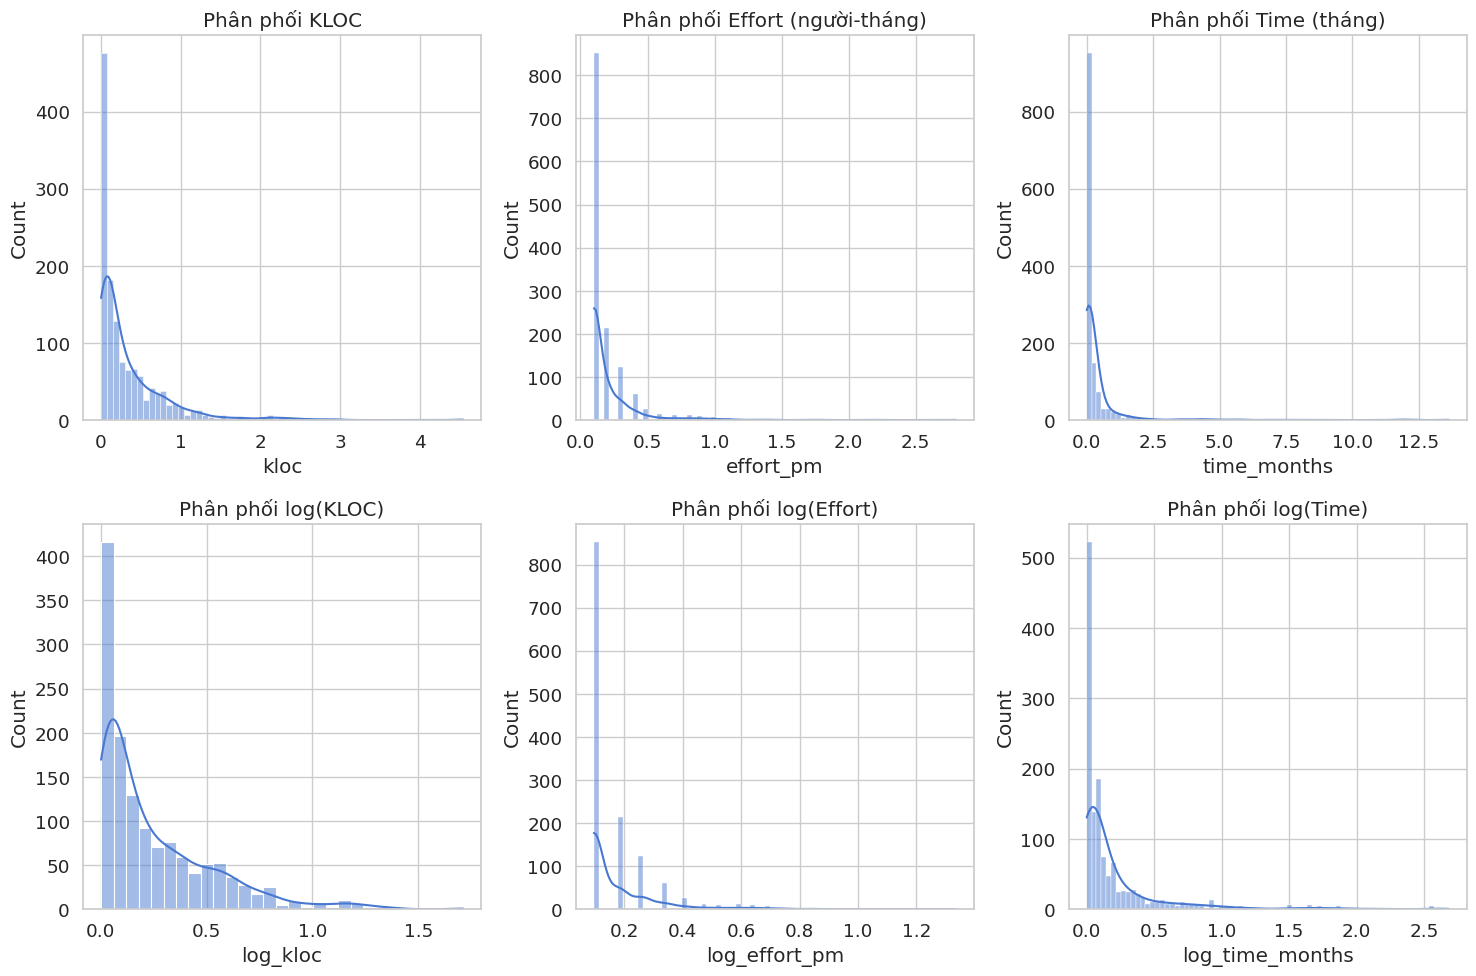

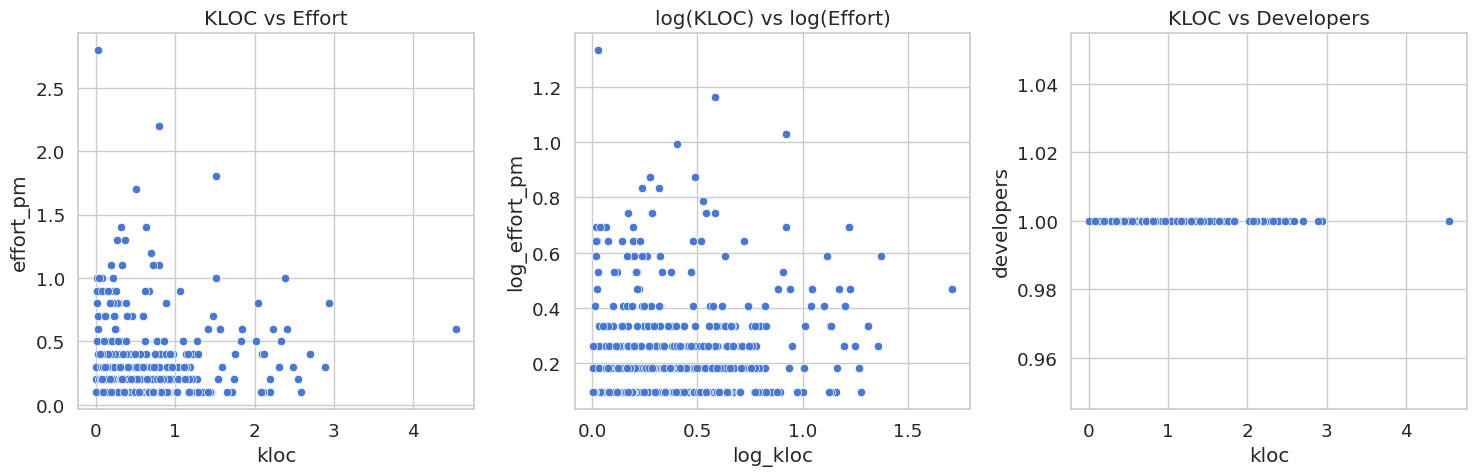

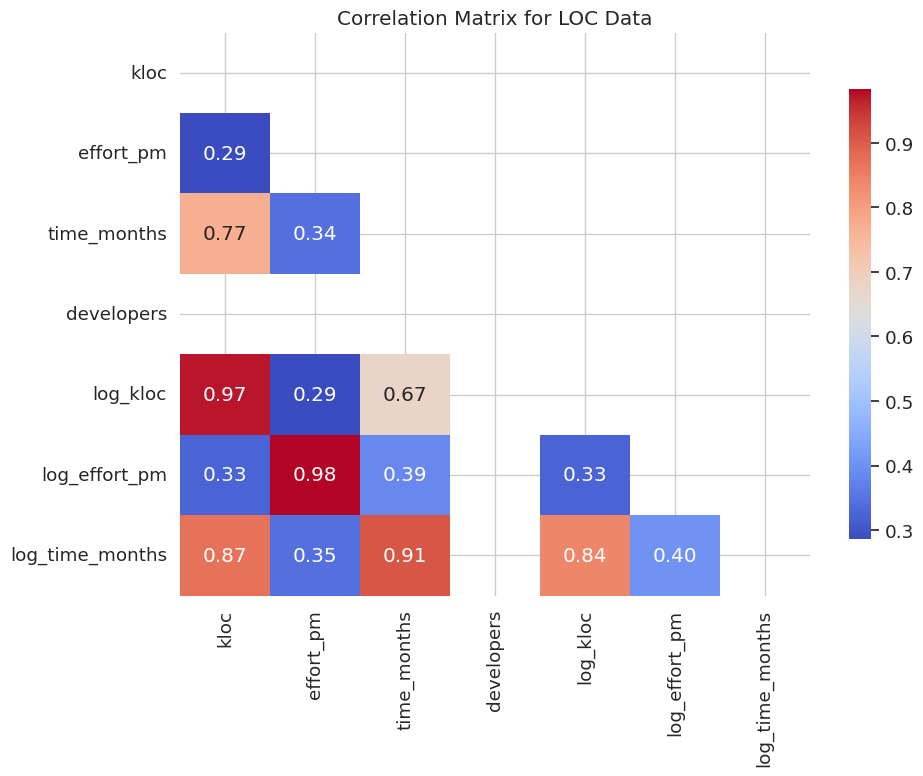


Biến đổi và trực quan hóa dữ liệu FP:


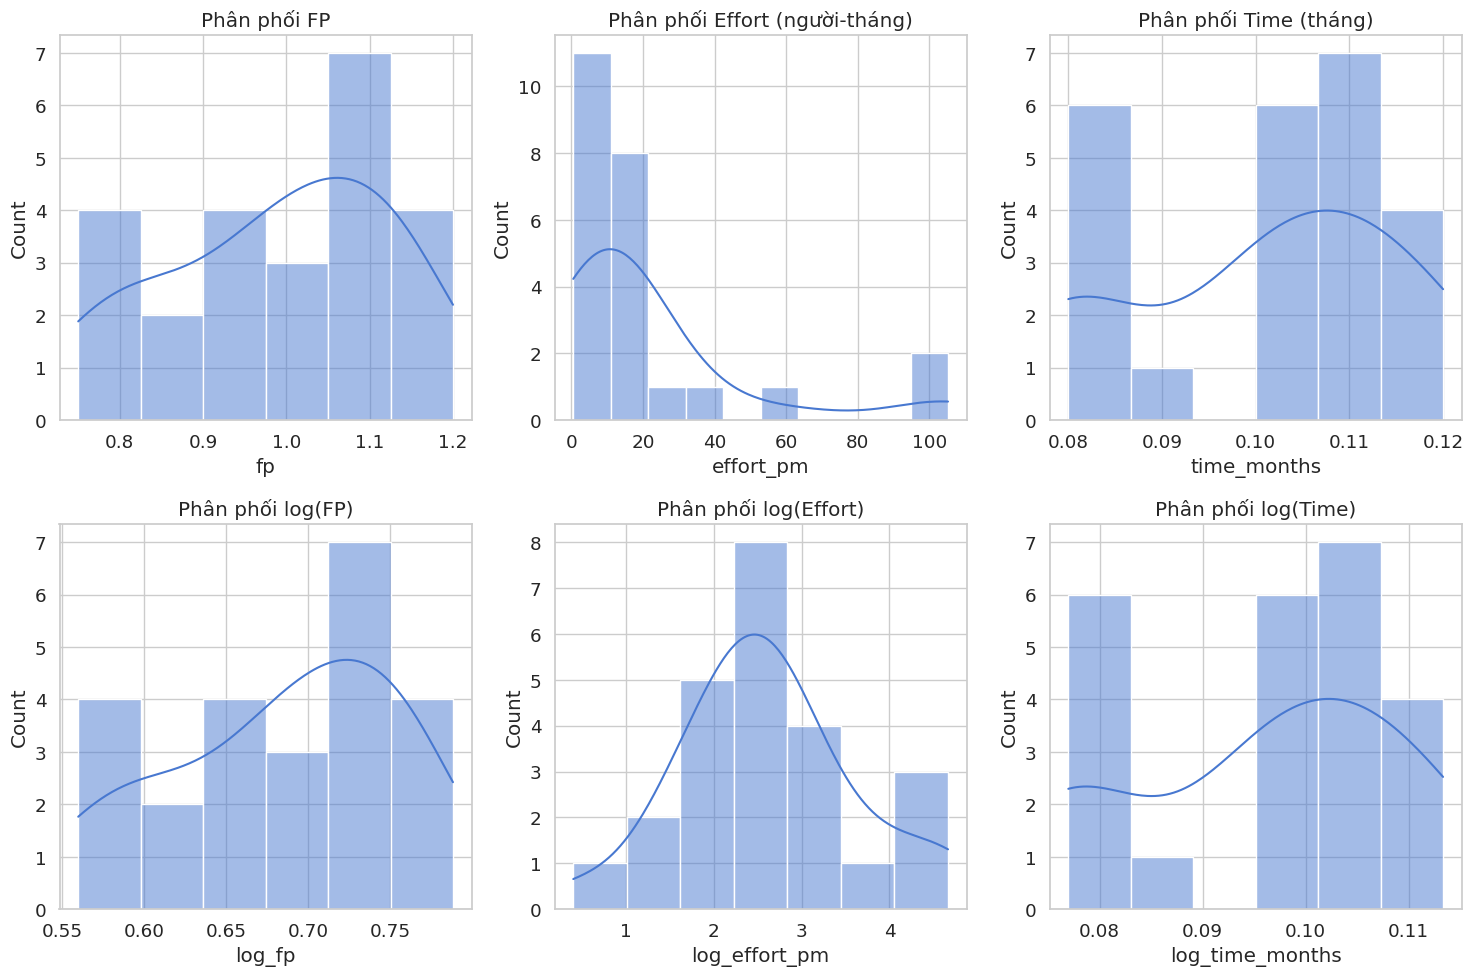

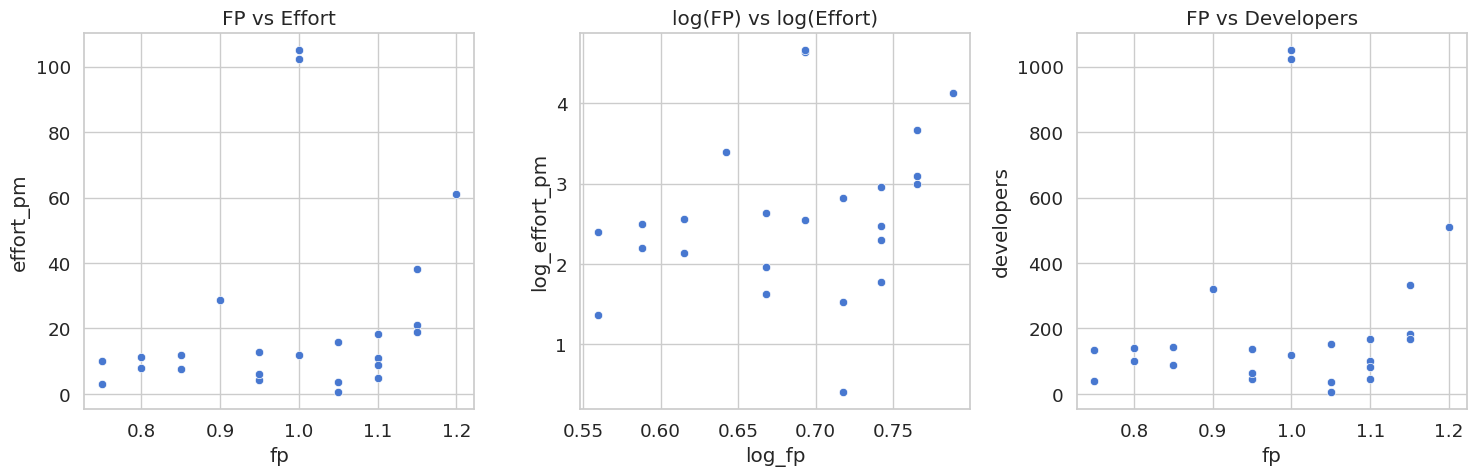

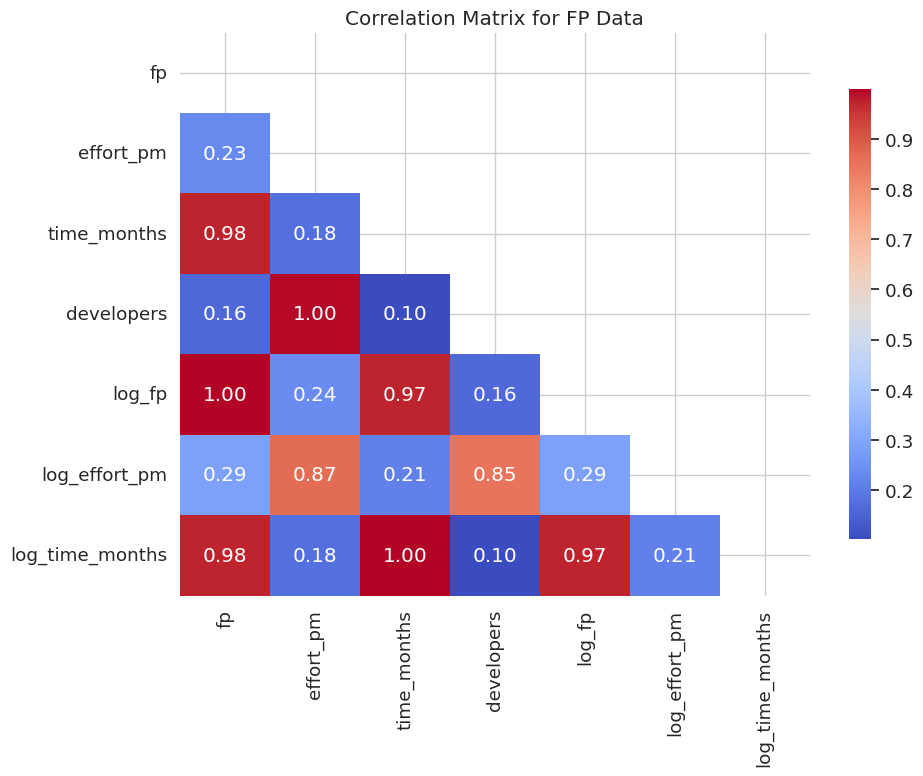

Không có dữ liệu UCP để trực quan hóa!


In [27]:
# Biến đổi dữ liệu và trực quan hóa cho schema LOC
if 'loc_combined_df' in locals() and not loc_combined_df.empty:
    print("Biến đổi và trực quan hóa dữ liệu LOC:")
    
    # Tạo bản sao để không ảnh hưởng đến dữ liệu gốc
    loc_transformed = loc_combined_df.copy()
    
    # Biến đổi logarithmic cho các cột số
    for col in ['kloc', 'effort_pm', 'time_months']:
        if col in loc_transformed.columns:
            # Thêm 1 để tránh log(0)
            loc_transformed[f'log_{col}'] = np.log1p(loc_transformed[col])
    
    # Trực quan hóa phân phối dữ liệu
    plt.figure(figsize=(15, 10))
    
    # Biểu đồ phân phối cho dữ liệu gốc
    plt.subplot(2, 3, 1)
    sns.histplot(loc_transformed['kloc'], kde=True)
    plt.title('Phân phối KLOC')
    
    plt.subplot(2, 3, 2)
    sns.histplot(loc_transformed['effort_pm'], kde=True)
    plt.title('Phân phối Effort (người-tháng)')
    
    plt.subplot(2, 3, 3)
    sns.histplot(loc_transformed['time_months'], kde=True)
    plt.title('Phân phối Time (tháng)')
    
    # Biểu đồ phân phối cho dữ liệu đã log transform
    plt.subplot(2, 3, 4)
    sns.histplot(loc_transformed['log_kloc'], kde=True)
    plt.title('Phân phối log(KLOC)')
    
    plt.subplot(2, 3, 5)
    sns.histplot(loc_transformed['log_effort_pm'], kde=True)
    plt.title('Phân phối log(Effort)')
    
    plt.subplot(2, 3, 6)
    sns.histplot(loc_transformed['log_time_months'], kde=True)
    plt.title('Phân phối log(Time)')
    
    plt.tight_layout()
    plt.show()
    
    # Biểu đồ scatter để hiển thị mối quan hệ giữa các biến
    plt.figure(figsize=(15, 5))
    
    # KLOC vs Effort
    plt.subplot(1, 3, 1)
    sns.scatterplot(x='kloc', y='effort_pm', data=loc_transformed)
    plt.title('KLOC vs Effort')
    
    # log(KLOC) vs log(Effort) - Mối quan hệ tuyến tính hơn sau khi log transform
    plt.subplot(1, 3, 2)
    sns.scatterplot(x='log_kloc', y='log_effort_pm', data=loc_transformed)
    plt.title('log(KLOC) vs log(Effort)')
    
    # KLOC vs Developers
    plt.subplot(1, 3, 3)
    sns.scatterplot(x='kloc', y='developers', data=loc_transformed)
    plt.title('KLOC vs Developers')
    
    plt.tight_layout()
    plt.show()
    
    # Biểu đồ heatmap thể hiện tương quan giữa các biến
    plt.figure(figsize=(10, 8))
    numeric_cols = ['kloc', 'effort_pm', 'time_months', 'developers', 
                    'log_kloc', 'log_effort_pm', 'log_time_months']
    correlation = loc_transformed[numeric_cols].corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))
    sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', mask=mask, cbar_kws={'shrink': .8})
    plt.title('Correlation Matrix for LOC Data')
    plt.tight_layout()
    plt.show()
else:
    print("Không có dữ liệu LOC để trực quan hóa!")
    
# Biến đổi dữ liệu và trực quan hóa cho schema FP
if 'fp_combined_df' in locals() and not fp_combined_df.empty:
    print("\nBiến đổi và trực quan hóa dữ liệu FP:")
    
    # Tạo bản sao để không ảnh hưởng đến dữ liệu gốc
    fp_transformed = fp_combined_df.copy()
    
    # Biến đổi logarithmic cho các cột số
    for col in ['fp', 'effort_pm', 'time_months']:
        if col in fp_transformed.columns:
            # Thêm 1 để tránh log(0)
            fp_transformed[f'log_{col}'] = np.log1p(fp_transformed[col])
    
    # Trực quan hóa phân phối dữ liệu
    plt.figure(figsize=(15, 10))
    
    # Biểu đồ phân phối cho dữ liệu gốc
    plt.subplot(2, 3, 1)
    sns.histplot(fp_transformed['fp'], kde=True)
    plt.title('Phân phối FP')
    
    plt.subplot(2, 3, 2)
    sns.histplot(fp_transformed['effort_pm'], kde=True)
    plt.title('Phân phối Effort (người-tháng)')
    
    plt.subplot(2, 3, 3)
    sns.histplot(fp_transformed['time_months'], kde=True)
    plt.title('Phân phối Time (tháng)')
    
    # Biểu đồ phân phối cho dữ liệu đã log transform
    plt.subplot(2, 3, 4)
    sns.histplot(fp_transformed['log_fp'], kde=True)
    plt.title('Phân phối log(FP)')
    
    plt.subplot(2, 3, 5)
    sns.histplot(fp_transformed['log_effort_pm'], kde=True)
    plt.title('Phân phối log(Effort)')
    
    plt.subplot(2, 3, 6)
    sns.histplot(fp_transformed['log_time_months'], kde=True)
    plt.title('Phân phối log(Time)')
    
    plt.tight_layout()
    plt.show()
    
    # Biểu đồ scatter để hiển thị mối quan hệ giữa các biến
    plt.figure(figsize=(15, 5))
    
    # FP vs Effort
    plt.subplot(1, 3, 1)
    sns.scatterplot(x='fp', y='effort_pm', data=fp_transformed)
    plt.title('FP vs Effort')
    
    # log(FP) vs log(Effort) - Mối quan hệ tuyến tính hơn sau khi log transform
    plt.subplot(1, 3, 2)
    sns.scatterplot(x='log_fp', y='log_effort_pm', data=fp_transformed)
    plt.title('log(FP) vs log(Effort)')
    
    # FP vs Developers
    plt.subplot(1, 3, 3)
    sns.scatterplot(x='fp', y='developers', data=fp_transformed)
    plt.title('FP vs Developers')
    
    plt.tight_layout()
    plt.show()
    
    # Biểu đồ heatmap thể hiện tương quan giữa các biến
    plt.figure(figsize=(10, 8))
    numeric_cols = ['fp', 'effort_pm', 'time_months', 'developers', 
                    'log_fp', 'log_effort_pm', 'log_time_months']
    correlation = fp_transformed[numeric_cols].corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))
    sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', mask=mask, cbar_kws={'shrink': .8})
    plt.title('Correlation Matrix for FP Data')
    plt.tight_layout()
    plt.show()
else:
    print("Không có dữ liệu FP để trực quan hóa!")
    
# Biến đổi dữ liệu và trực quan hóa cho schema UCP
if 'ucp_combined_df' in locals() and not ucp_combined_df.empty:
    print("\nBiến đổi và trực quan hóa dữ liệu UCP:")
    
    # Tạo bản sao để không ảnh hưởng đến dữ liệu gốc
    ucp_transformed = ucp_combined_df.copy()
    
    # Biến đổi logarithmic cho các cột số
    for col in ['ucp', 'effort_pm', 'time_months']:
        if col in ucp_transformed.columns:
            # Thêm 1 để tránh log(0)
            ucp_transformed[f'log_{col}'] = np.log1p(ucp_transformed[col])
    
    # Trực quan hóa phân phối dữ liệu
    plt.figure(figsize=(15, 10))
    
    # Biểu đồ phân phối cho dữ liệu gốc
    plt.subplot(2, 3, 1)
    sns.histplot(ucp_transformed['ucp'], kde=True)
    plt.title('Phân phối UCP')
    
    plt.subplot(2, 3, 2)
    sns.histplot(ucp_transformed['effort_pm'], kde=True)
    plt.title('Phân phối Effort (người-tháng)')
    
    plt.subplot(2, 3, 3)
    sns.histplot(ucp_transformed['time_months'], kde=True)
    plt.title('Phân phối Time (tháng)')
    
    # Biểu đồ phân phối cho dữ liệu đã log transform
    plt.subplot(2, 3, 4)
    sns.histplot(ucp_transformed['log_ucp'], kde=True)
    plt.title('Phân phối log(UCP)')
    
    plt.subplot(2, 3, 5)
    sns.histplot(ucp_transformed['log_effort_pm'], kde=True)
    plt.title('Phân phối log(Effort)')
    
    plt.subplot(2, 3, 6)
    sns.histplot(ucp_transformed['log_time_months'], kde=True)
    plt.title('Phân phối log(Time)')
    
    plt.tight_layout()
    plt.show()
    
    # Biểu đồ scatter để hiển thị mối quan hệ giữa các biến
    plt.figure(figsize=(15, 5))
    
    # UCP vs Effort
    plt.subplot(1, 3, 1)
    sns.scatterplot(x='ucp', y='effort_pm', data=ucp_transformed)
    plt.title('UCP vs Effort')
    
    # log(UCP) vs log(Effort) - Mối quan hệ tuyến tính hơn sau khi log transform
    plt.subplot(1, 3, 2)
    sns.scatterplot(x='log_ucp', y='log_effort_pm', data=ucp_transformed)
    plt.title('log(UCP) vs log(Effort)')
    
    # UCP vs Developers
    plt.subplot(1, 3, 3)
    sns.scatterplot(x='ucp', y='developers', data=ucp_transformed)
    plt.title('UCP vs Developers')
    
    plt.tight_layout()
    plt.show()
    
    # Biểu đồ heatmap thể hiện tương quan giữa các biến
    plt.figure(figsize=(10, 8))
    numeric_cols = ['ucp', 'effort_pm', 'time_months', 'developers', 
                    'log_ucp', 'log_effort_pm', 'log_time_months']
    correlation = ucp_transformed[numeric_cols].corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))
    sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', mask=mask, cbar_kws={'shrink': .8})
    plt.title('Correlation Matrix for UCP Data')
    plt.tight_layout()
    plt.show()
else:
    print("Không có dữ liệu UCP để trực quan hóa!")

In [28]:
# Hàm chuẩn hóa dữ liệu Function Points
def normalize_fp_data(df, source):
    """
    Chuẩn hóa dữ liệu từ các nguồn khác nhau thành định dạng thống nhất cho schema FP
    
    Args:
        df: DataFrame gốc
        source: Tên nguồn dữ liệu
        
    Returns:
        DataFrame đã chuẩn hóa với các cột: fp, effort_pm, time_months, developers
    """
    normalized_df = pd.DataFrame()
    
    # Copy source
    normalized_df['source'] = df['source']
    
    # Xử lý dữ liệu theo từng nguồn
    if 'albrecht.arff' in source:
        # FP: Lấy từ cột AFP (Adjusted Function Points)
        if 'AFP' in df.columns:
            normalized_df['fp'] = pd.to_numeric(df['AFP'], errors='coerce')
        elif 'AdjFP' in df.columns:
            normalized_df['fp'] = pd.to_numeric(df['AdjFP'], errors='coerce')
        elif 'adjfp' in df.columns:
            normalized_df['fp'] = pd.to_numeric(df['adjfp'], errors='coerce')
        else:
            # Nếu không có AFP, thử lấy từ FP hoặc rawfpcounts
            if 'FP' in df.columns:
                normalized_df['fp'] = pd.to_numeric(df['FP'], errors='coerce')
            elif 'rawfpcounts' in df.columns:
                normalized_df['fp'] = pd.to_numeric(df['rawfpcounts'], errors='coerce')
            
        # Effort: Lấy từ cột Effort (người-tháng)
        if 'Effort' in df.columns:
            normalized_df['effort_pm'] = pd.to_numeric(df['Effort'], errors='coerce')
        elif 'effort' in df.columns:
            normalized_df['effort_pm'] = pd.to_numeric(df['effort'], errors='coerce')
        else:
            # Ước tính effort từ fp nếu có fp
            if 'fp' in normalized_df.columns:
                normalized_df['effort_pm'] = normalized_df['fp'] * 0.2
            
        # Time: Nếu có cột Duration hoặc Time
        if 'Duration' in df.columns:
            normalized_df['time_months'] = pd.to_numeric(df['Duration'], errors='coerce')
        elif 'Time' in df.columns:
            normalized_df['time_months'] = pd.to_numeric(df['Time'], errors='coerce')
        elif 'Months' in df.columns:
            normalized_df['time_months'] = pd.to_numeric(df['Months'], errors='coerce')
        else:
            # Ước tính time từ fp nếu có fp
            if 'fp' in normalized_df.columns:
                normalized_df['time_months'] = normalized_df['fp'] * 0.1
            
        # Developers: Nếu có cột Staff hoặc Team
        if 'Team' in df.columns:
            normalized_df['developers'] = pd.to_numeric(df['Team'], errors='coerce')
        elif 'Staff' in df.columns:
            normalized_df['developers'] = pd.to_numeric(df['Staff'], errors='coerce')
        else:
            # Ước tính developers từ effort và time
            # Formula: developers = effort / time
            # Đảm bảo không có giá trị NaN trước khi tính toán
            mask = (normalized_df.get('effort_pm', pd.Series()).notna() & 
                   normalized_df.get('time_months', pd.Series()).notna() & 
                   (normalized_df.get('time_months', pd.Series()) > 0))
            
            if 'effort_pm' in normalized_df.columns and 'time_months' in normalized_df.columns:
                normalized_df.loc[mask, 'developers'] = np.ceil(normalized_df.loc[mask, 'effort_pm'] / normalized_df.loc[mask, 'time_months'])
                # Gán giá trị mặc định cho các hàng không thỏa mãn điều kiện
                normalized_df['developers'] = normalized_df.get('developers', pd.Series()).fillna(1)
            else:
                normalized_df['developers'] = 1
    
    elif 'Subbiah.csv' in source:
        # FP: Lấy từ cột TotalUFP (Total Unadjusted Function Points)
        if 'TotalUFP' in df.columns:
            normalized_df['fp'] = pd.to_numeric(df['TotalUFP'], errors='coerce')
            
        # Effort: Lấy từ cột ActualEffort hoặc TotalLaborCost nếu có
        if 'ActualEffort' in df.columns:
            normalized_df['effort_pm'] = pd.to_numeric(df['ActualEffort'], errors='coerce')
        elif 'Effort' in df.columns:
            normalized_df['effort_pm'] = pd.to_numeric(df['Effort'], errors='coerce')
        elif 'TotalLaborCost' in df.columns:
            # Chuyển đổi chi phí thành effort, giả định 10000 đơn vị = 1 người-tháng
            normalized_df['effort_pm'] = pd.to_numeric(df['TotalLaborCost'], errors='coerce') / 10000
        else:
            # Ước tính effort từ fp nếu có fp
            if 'fp' in normalized_df.columns:
                normalized_df['effort_pm'] = normalized_df['fp'] * 0.2
            
        # Time: Ước tính từ fp nếu có fp
        if 'fp' in normalized_df.columns:
            normalized_df['time_months'] = normalized_df['fp'] * 0.1
        
        # Developers: Ước tính từ effort và time
        # Đảm bảo không có giá trị NaN trước khi tính toán
        mask = (normalized_df.get('effort_pm', pd.Series()).notna() & 
               normalized_df.get('time_months', pd.Series()).notna() & 
               (normalized_df.get('time_months', pd.Series()) > 0))
        
        if 'effort_pm' in normalized_df.columns and 'time_months' in normalized_df.columns:
            normalized_df.loc[mask, 'developers'] = np.ceil(normalized_df.loc[mask, 'effort_pm'] / normalized_df.loc[mask, 'time_months'])
            # Gán giá trị mặc định cho các hàng không thỏa mãn điều kiện
            normalized_df['developers'] = normalized_df.get('developers', pd.Series()).fillna(1)
        else:
            normalized_df['developers'] = 1
    
    else:
        # Không thuộc các nguồn đã biết, thử xác định dựa vào tên cột
        
        # Cố gắng tìm cột liên quan đến FP
        fp_found = False
        for col in df.columns:
            col_lower = str(col).lower()
            if 'fp' in col_lower or 'function point' in col_lower or 'functionpoint' in col_lower:
                normalized_df['fp'] = pd.to_numeric(df[col], errors='coerce')
                fp_found = True
                break
                
        if not fp_found:
            print(f"Không tìm thấy cột FP trong file {source}. Cột hiện có: {', '.join(map(str, df.columns))}")
            return pd.DataFrame()  # Trả về DataFrame rỗng
            
        # Cố gắng tìm cột liên quan đến effort
        effort_found = False
        for col in df.columns:
            col_lower = str(col).lower()
            if 'effort' in col_lower or 'pm' in col_lower or 'person' in col_lower:
                normalized_df['effort_pm'] = pd.to_numeric(df[col], errors='coerce')
                effort_found = True
                break
                
        if not effort_found:
            # Ước tính effort từ fp
            normalized_df['effort_pm'] = normalized_df['fp'] * 0.2
            
        # Ước tính time và developers nếu không tìm thấy
        time_found = False
        for col in df.columns:
            col_lower = str(col).lower()
            if 'time' in col_lower or 'month' in col_lower or 'duration' in col_lower:
                normalized_df['time_months'] = pd.to_numeric(df[col], errors='coerce')
                time_found = True
                break
                
        if not time_found:
            # Ước tính time từ fp
            normalized_df['time_months'] = normalized_df['fp'] * 0.1
            
        # Ước tính developers từ effort và time
        developers_found = False
        for col in df.columns:
            col_lower = str(col).lower()
            if 'dev' in col_lower or 'staff' in col_lower or 'team' in col_lower:
                normalized_df['developers'] = pd.to_numeric(df[col], errors='coerce')
                developers_found = True
                break
                
        if not developers_found:
            # Ước tính developers từ effort và time
            # Đảm bảo không có giá trị NaN trước khi tính toán
            mask = (normalized_df.get('effort_pm', pd.Series()).notna() & 
                   normalized_df.get('time_months', pd.Series()).notna() & 
                   (normalized_df.get('time_months', pd.Series()) > 0))
            
            if 'effort_pm' in normalized_df.columns and 'time_months' in normalized_df.columns:
                normalized_df.loc[mask, 'developers'] = np.ceil(normalized_df.loc[mask, 'effort_pm'] / normalized_df.loc[mask, 'time_months'])
                # Gán giá trị mặc định cho các hàng không thỏa mãn điều kiện
                normalized_df['developers'] = normalized_df.get('developers', pd.Series()).fillna(1)
            else:
                normalized_df['developers'] = 1
    
    # Kiểm tra xem có cột fp không
    if 'fp' not in normalized_df.columns or normalized_df['fp'].isna().all():
        print(f"Không thể xác định giá trị FP cho nguồn dữ liệu {source}")
        return pd.DataFrame()  # Trả về DataFrame rỗng
    
    # Loại bỏ các hàng có giá trị null hoặc âm ở các cột quan trọng
    for col in ['fp', 'effort_pm', 'time_months', 'developers']:
        if col in normalized_df.columns:
            valid_before = len(normalized_df)
            normalized_df = normalized_df[(normalized_df[col].notna()) & (normalized_df[col] > 0)]
            if valid_before > len(normalized_df):
                print(f"Đã loại bỏ {valid_before - len(normalized_df)} hàng với {col} là NaN hoặc ≤ 0")
    
    # Làm tròn các giá trị số để dễ đọc
    for col in ['fp', 'effort_pm', 'time_months']:
        if col in normalized_df.columns:
            normalized_df[col] = normalized_df[col].astype(float).round(2)
    
    if 'developers' in normalized_df.columns:
        normalized_df['developers'] = normalized_df['developers'].astype(int)
    
    return normalized_df

# Kiểm tra dataframes['fp'] và các cột hiện có
if dataframes['fp']:
    print(f"Số lượng DataFrame FP: {len(dataframes['fp'])}")
    for i, df in enumerate(dataframes['fp']):
        source = df['source'].iloc[0]
        print(f"\nDataFrame {i+1}: {source}")
        print(f"Shape: {df.shape}")
        print("Columns:")
        for col in df.columns:
            print(f"  - {col} ({df[col].dtype})")
        
        # Hiển thị một số dòng đầu tiên
        print("\nMẫu dữ liệu:")
        print(df.head(3))
else:
    print("Không có dữ liệu FP nào được tìm thấy!")

# Áp dụng chuẩn hóa cho từng DataFrame FP
fp_normalized_dfs = []

if dataframes['fp']:
    for df in dataframes['fp']:
        source = df['source'].iloc[0]
        print(f"\nĐang chuẩn hóa dữ liệu FP từ nguồn {source}...")
        normalized_df = normalize_fp_data(df, source)
        if not normalized_df.empty:
            fp_normalized_dfs.append(normalized_df)
            print(f"Đã chuẩn hóa dữ liệu {source}: {normalized_df.shape[0]} dòng")
        else:
            print(f"Không thể chuẩn hóa dữ liệu từ {source}")

# Kết hợp tất cả các DataFrame đã chuẩn hóa
if fp_normalized_dfs:
    fp_combined_df = pd.concat(fp_normalized_dfs, ignore_index=True)
    print(f"\nTổng số dữ liệu FP sau khi chuẩn hóa: {fp_combined_df.shape[0]} dòng × {fp_combined_df.shape[1]} cột")
    
    # Hiển thị mẫu dữ liệu
    print("\nMẫu dữ liệu FP sau khi chuẩn hóa:")
    print(fp_combined_df.sample(min(5, len(fp_combined_df))))
else:
    print("Không có dữ liệu FP nào được chuẩn hóa thành công!")
    fp_combined_df = pd.DataFrame()

# Debug dataframes['fp']
if 'fp' in dataframes and dataframes['fp']:
    print(f"Số lượng DataFrame FP: {len(dataframes['fp'])}")
    for i, df in enumerate(dataframes['fp']):
        if 'source' in df.columns:
            source = df['source'].iloc[0]
            print(f"\nDataFrame {i+1}: {source}")
        else:
            print(f"\nDataFrame {i+1}: Unknown source")
        
        print(f"Shape: {df.shape}")
        print("Columns:")
        for col in df.columns:
            print(f"  - {col} ({df[col].dtype})")
        
        # Hiển thị một số dòng đầu tiên
        print("\nMẫu dữ liệu:")
        print(df.head(3))
else:
    print("Không có dữ liệu FP nào được tìm thấy hoặc dataframes['fp'] không tồn tại!")

Số lượng DataFrame FP: 2

DataFrame 1: albrecht.arff
Shape: (24, 9)
Columns:
  - input (int64)
  - output (int64)
  - inquiry (int64)
  - file (int64)
  - fpadj (float64)
  - rawfpcounts (float64)
  - adjfp (int64)
  - effort (float64)
  - source (object)

Mẫu dữ liệu:
   input  output  inquiry  file  fpadj  rawfpcounts  adjfp   effort         source
0     25     150       75    60 1.0000    1750.0000   1750 102.4000  albrecht.arff
1    193      98       70    36 1.0000    1902.0000   1902 105.2000  albrecht.arff
2     70      27        0    12 0.8000     535.0000    428  11.1000  albrecht.arff

DataFrame 2: Subbiah.csv
Shape: (72, 13)
Columns:
  - Project (object)
  - Actual des (int64)
  - Adjustment (float64)
  - CostPerFP (int64)
  - ExternalInterface (int64)
  - ExternalInputs (int64)
  - ExternalOutputs (int64)
  - ExternalQueries (int64)
  - HoursToCount (float64)
  - InternalLogicalFiles (int64)
  - TotalLaborCost (int64)
  - TotalUFP (int64)
  - source (object)

Mẫu dữ liệu:
 

## 8. Xuất Dữ Liệu Đã Chuẩn Hóa

Cuối cùng, chúng ta sẽ xuất dữ liệu đã chuẩn hóa ra các file CSV để có thể sử dụng cho các bước phân tích và mô hình hóa tiếp theo. Mỗi schema (LOC, FP, UCP) sẽ được xuất ra một file riêng.

In [31]:
# Xuất dữ liệu đã chuẩn hóa ra các file CSV
import os
import json
import datetime

# Tạo thư mục đầu ra nếu chưa tồn tại
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"Đã tạo thư mục đầu ra: {OUTPUT_DIR}")

# Hàm lưu DataFrame vào file CSV với thông tin metadata
def save_normalized_data(df, schema, output_dir):
    """
    Lưu DataFrame đã chuẩn hóa vào file CSV và cập nhật metadata
    
    Args:
        df: DataFrame đã chuẩn hóa
        schema: Tên schema (LOC, FP, UCP)
        output_dir: Thư mục đầu ra
    """
    if df.empty:
        print(f"Không có dữ liệu {schema} để xuất!")
        return
    
    # Tên file output
    output_file = os.path.join(output_dir, f"{schema.lower()}_based.csv")
    
    # Lưu DataFrame vào file CSV
    df.to_csv(output_file, index=False)
    print(f"Đã lưu dữ liệu {schema} vào file: {output_file}")
    
    # Cập nhật metadata
    metadata_file = os.path.join(output_dir, "metadata.json")
    metadata = {}
    
    if os.path.exists(metadata_file):
        try:
            with open(metadata_file, 'r') as f:
                metadata = json.load(f)
        except:
            metadata = {}
    
    # Cập nhật thông tin cho schema hiện tại
    metadata[schema] = {
        'file': f"{schema.lower()}_based.csv",
        'rows': len(df),
        'columns': list(df.columns),
        'sources': df['source'].unique().tolist(),
        'timestamp': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
    
    # Lưu metadata
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=4)
    
    print(f"Đã cập nhật metadata cho schema {schema}")

# Xuất dữ liệu LOC
if 'loc_clean_df_outliers' in locals() and not loc_clean_df_outliers.empty:
    save_normalized_data(loc_clean_df_outliers, 'LOC', OUTPUT_DIR)
elif 'loc_combined_df' in locals() and not loc_combined_df.empty:
    save_normalized_data(loc_combined_df, 'LOC', OUTPUT_DIR)
else:
    print("Không có dữ liệu LOC đã chuẩn hóa để xuất!")

# Xuất dữ liệu FP
if 'fp_combined_df' in locals() and not fp_combined_df.empty:
    save_normalized_data(fp_combined_df, 'FP', OUTPUT_DIR)
else:
    print("Không có dữ liệu FP đã chuẩn hóa để xuất!")

# Xuất dữ liệu UCP
if 'ucp_combined_df' in locals() and not ucp_combined_df.empty:
    save_normalized_data(ucp_combined_df, 'UCP', OUTPUT_DIR)
else:
    print("Không có dữ liệu UCP đã chuẩn hóa để xuất!")

Đã lưu dữ liệu LOC vào file: /home/huy/Huy-workspace/AI-Project/processed_data/loc_based.csv
Đã cập nhật metadata cho schema LOC
Đã lưu dữ liệu FP vào file: /home/huy/Huy-workspace/AI-Project/processed_data/fp_based.csv
Đã cập nhật metadata cho schema FP
Không có dữ liệu UCP đã chuẩn hóa để xuất!


In [33]:
# Hàm chuẩn hóa dữ liệu UCP
def normalize_ucp_data(df, source):
    """
    Chuẩn hóa dữ liệu từ các nguồn khác nhau thành định dạng thống nhất cho schema UCP
    
    Args:
        df: DataFrame gốc
        source: Tên nguồn dữ liệu
        
    Returns:
        DataFrame đã chuẩn hóa với các cột: ucp, effort_pm, time_months, developers
    """
    normalized_df = pd.DataFrame()
    
    # Copy source
    normalized_df['source'] = df['source']
    
    # Xử lý UCP_Dataset.csv
    if 'UCP_Dataset.csv' in source:
        # Kiểm tra các cột cần thiết
        print(f"Cột trong UCP_Dataset: {', '.join(df.columns)}")
        
        # Giá trị mặc định cho các trường hợp thiếu
        default_tcf = 1.0
        default_ecf = 1.0
        
        # Thử các cách khác nhau để tìm/tính UCP
        ucp_found = False
        
        # Trường hợp 1: Nếu có cột UCP trực tiếp
        if 'UCP' in df.columns:
            normalized_df['ucp'] = pd.to_numeric(df['UCP'], errors='coerce')
            ucp_found = True
        
        # Trường hợp 2: Tính UCP từ UAW và UUCW, dùng giá trị mặc định cho TCF và ECF nếu cần
        elif all(col in df.columns for col in ['UAW', 'UUCW']):
            # Lấy giá trị UAW, UUCW
            uaw = pd.to_numeric(df['UAW'], errors='coerce')
            uucw = pd.to_numeric(df['UUCW'], errors='coerce')
            
            # Lấy giá trị TCF, ECF nếu có, nếu không dùng giá trị mặc định
            if 'TCF' in df.columns:
                tcf = pd.to_numeric(df['TCF'], errors='coerce').fillna(default_tcf)
            else:
                print(f"Không tìm thấy cột TCF, dùng giá trị mặc định: {default_tcf}")
                tcf = pd.Series([default_tcf] * len(df))
                
            if 'ECF' in df.columns:
                ecf = pd.to_numeric(df['ECF'], errors='coerce').fillna(default_ecf)
            else:
                print(f"Không tìm thấy cột ECF, dùng giá trị mặc định: {default_ecf}")
                ecf = pd.Series([default_ecf] * len(df))
            
            # Tính UCP
            normalized_df['ucp'] = (uaw + uucw) * tcf * ecf
            ucp_found = True
            
            # Thêm các thành phần của UCP để tham khảo
            normalized_df['uaw'] = uaw
            normalized_df['uucw'] = uucw
            normalized_df['tcf'] = tcf
            normalized_df['ecf'] = ecf
        
        # Nếu không tìm thấy dữ liệu UCP phù hợp
        if not ucp_found:
            print("Không thể tính UCP từ dữ liệu hiện có!")
            return pd.DataFrame()
        
        # Lấy effort từ Real_Effort_Person_Hours hoặc các cột tương tự
        if 'Real_Effort_Person_Hours' in df.columns:
            # Chuyển giờ thành người-tháng (1 người-tháng = 160 giờ)
            normalized_df['effort_pm'] = pd.to_numeric(df['Real_Effort_Person_Hours'], errors='coerce') / 160
        elif 'Effort' in df.columns:
            normalized_df['effort_pm'] = pd.to_numeric(df['Effort'], errors='coerce')
        else:
            # Ước tính effort từ UCP (20 giờ/UCP)
            normalized_df['effort_pm'] = normalized_df['ucp'] * 20 / 160
        
        # Lấy hoặc ước tính thời gian
        if 'Real_P20' in df.columns:
            # P20 là năng suất, thời gian = Effort / P20
            real_p20 = pd.to_numeric(df['Real_P20'], errors='coerce')
            # Tránh chia cho 0
            real_p20 = real_p20.replace(0, np.nan)
            
            time_mask = normalized_df['effort_pm'].notna() & real_p20.notna()
            normalized_df.loc[time_mask, 'time_months'] = normalized_df.loc[time_mask, 'effort_pm'] / real_p20.loc[time_mask]
            
            # Điền các giá trị còn thiếu bằng ước tính
            missing_time_mask = normalized_df['time_months'].isna() & normalized_df['ucp'].notna()
            normalized_df.loc[missing_time_mask, 'time_months'] = normalized_df.loc[missing_time_mask, 'ucp'] * 0.2
        else:
            # Ước tính thời gian từ UCP
            normalized_df['time_months'] = normalized_df['ucp'] * 0.2
        
        # Ước tính số lượng developers
        mask = (normalized_df['effort_pm'].notna()) & (normalized_df['time_months'] > 0)
        normalized_df.loc[mask, 'developers'] = np.ceil(normalized_df.loc[mask, 'effort_pm'] / normalized_df.loc[mask, 'time_months'])
        normalized_df['developers'] = normalized_df['developers'].fillna(1)
        
        # Thêm các thuộc tính bổ sung nếu có
        for col in ['Sector', 'Language', 'Methodology', 'ApplicationType', 'Project_No']:
            if col in df.columns:
                normalized_df[col.lower()] = df[col]
    
    # Xử lý cho các file UCP khác
    else:
        # Cố gắng tìm cột liên quan đến UCP
        ucp_found = False
        for col in df.columns:
            col_lower = str(col).lower()
            if 'ucp' in col_lower or 'use case point' in col_lower:
                normalized_df['ucp'] = pd.to_numeric(df[col], errors='coerce')
                ucp_found = True
                break
        
        # Nếu không tìm thấy cột UCP trực tiếp, thử tính từ UAW, UUCW, TCF, ECF
        if not ucp_found:
            # Tìm các cột UAW và UUCW
            uaw_col = None
            uucw_col = None
            tcf_col = None
            ecf_col = None
            
            for col in df.columns:
                col_lower = str(col).lower()
                if 'uaw' in col_lower or 'actor' in col_lower:
                    uaw_col = col
                elif 'uucw' in col_lower or 'use case' in col_lower:
                    uucw_col = col
                elif 'tcf' in col_lower or 'technical' in col_lower:
                    tcf_col = col
                elif 'ecf' in col_lower or 'environment' in col_lower:
                    ecf_col = col
            
            # Nếu tìm thấy UAW và UUCW
            if uaw_col and uucw_col:
                uaw = pd.to_numeric(df[uaw_col], errors='coerce')
                uucw = pd.to_numeric(df[uucw_col], errors='coerce')
                
                # Lấy TCF và ECF nếu có, nếu không dùng giá trị mặc định
                tcf = pd.to_numeric(df[tcf_col], errors='coerce') if tcf_col else pd.Series([1.0] * len(df))
                ecf = pd.to_numeric(df[ecf_col], errors='coerce') if ecf_col else pd.Series([1.0] * len(df))
                
                # Tính UCP
                normalized_df['ucp'] = (uaw + uucw) * tcf * ecf
                ucp_found = True
                
                # Thêm các thành phần của UCP để tham khảo
                normalized_df['uaw'] = uaw
                normalized_df['uucw'] = uucw
                normalized_df['tcf'] = tcf
                normalized_df['ecf'] = ecf
        
        if not ucp_found:
            print(f"Không tìm thấy đủ thông tin để tính UCP từ file {source}")
            return pd.DataFrame()
        
        # Cố gắng tìm cột liên quan đến effort
        effort_found = False
        for col in df.columns:
            col_lower = str(col).lower()
            if 'effort' in col_lower or 'pm' in col_lower or 'person' in col_lower or 'hour' in col_lower:
                # Nếu đơn vị là giờ, chuyển về người-tháng (1 người-tháng = 160 giờ)
                if 'hour' in col_lower:
                    normalized_df['effort_pm'] = pd.to_numeric(df[col], errors='coerce') / 160
                else:
                    normalized_df['effort_pm'] = pd.to_numeric(df[col], errors='coerce')
                effort_found = True
                break
        
        if not effort_found:
            # Ước tính effort từ UCP (20 giờ/UCP)
            normalized_df['effort_pm'] = normalized_df['ucp'] * 20 / 160
        
        # Ước tính thời gian từ UCP
        normalized_df['time_months'] = normalized_df['ucp'] * 0.2
        
        # Ước tính số lượng developers
        mask = (normalized_df['effort_pm'].notna()) & (normalized_df['time_months'] > 0)
        normalized_df.loc[mask, 'developers'] = np.ceil(normalized_df.loc[mask, 'effort_pm'] / normalized_df.loc[mask, 'time_months'])
        normalized_df['developers'] = normalized_df['developers'].fillna(1)
    
    # Loại bỏ các hàng có giá trị null hoặc âm ở các cột quan trọng
    for col in ['ucp', 'effort_pm', 'time_months', 'developers']:
        if col in normalized_df.columns:
            valid_before = len(normalized_df)
            normalized_df = normalized_df[(normalized_df[col].notna()) & (normalized_df[col] > 0)]
            if valid_before > len(normalized_df):
                print(f"Đã loại bỏ {valid_before - len(normalized_df)} hàng với {col} là NaN hoặc ≤ 0")
    
    # Làm tròn các giá trị số để dễ đọc
    for col in ['ucp', 'effort_pm', 'time_months']:
        if col in normalized_df.columns:
            normalized_df[col] = normalized_df[col].astype(float).round(2)
    
    if 'developers' in normalized_df.columns:
        normalized_df['developers'] = normalized_df['developers'].astype(int)
    
    return normalized_df

# Áp dụng chuẩn hóa cho từng DataFrame UCP
ucp_normalized_dfs = []

if 'ucp' in dataframes and dataframes['ucp']:
    print(f"Số lượng DataFrame UCP: {len(dataframes['ucp'])}")
    for df in dataframes['ucp']:
        source = df['source'].iloc[0]
        print(f"\nĐang chuẩn hóa dữ liệu UCP từ nguồn {source}...")
        normalized_df = normalize_ucp_data(df, source)
        if not normalized_df.empty:
            ucp_normalized_dfs.append(normalized_df)
            print(f"Đã chuẩn hóa dữ liệu {source}: {normalized_df.shape[0]} dòng")
        else:
            print(f"Không thể chuẩn hóa dữ liệu từ {source}")

# Kết hợp tất cả các DataFrame đã chuẩn hóa
if ucp_normalized_dfs:
    ucp_combined_df = pd.concat(ucp_normalized_dfs, ignore_index=True)
    print(f"\nTổng số dữ liệu UCP sau khi chuẩn hóa: {ucp_combined_df.shape[0]} dòng × {ucp_combined_df.shape[1]} cột")
    
    # Hiển thị mẫu dữ liệu
    print("\nMẫu dữ liệu UCP sau khi chuẩn hóa:")
    print(ucp_combined_df.sample(min(5, len(ucp_combined_df))))
    
    # Xuất dữ liệu UCP đã chuẩn hóa
    save_normalized_data(ucp_combined_df, 'UCP', OUTPUT_DIR)
else:
    print("Không có dữ liệu UCP nào được chuẩn hóa thành công!")
    ucp_combined_df = pd.DataFrame()

Số lượng DataFrame UCP: 1

Đang chuẩn hóa dữ liệu UCP từ nguồn UCP_Dataset.csv...
Cột trong UCP_Dataset: Project_No, Simple Actors, Average Actors, Complex Actors, UAW, Simple UC, Average UC, Complex UC, UUCW, TCF, ECF, Real_P20, Real_Effort_Person_Hours, Sector, Language, Methodology, ApplicationType, DataDonator, source
Đã chuẩn hóa dữ liệu UCP_Dataset.csv: 71 dòng

Tổng số dữ liệu UCP sau khi chuẩn hóa: 71 dòng × 14 cột

Mẫu dữ liệu UCP sau khi chuẩn hóa:
             source      ucp  uaw  uucw    tcf    ecf  effort_pm  time_months  developers         sector      language methodology       applicationtype  project_no
36  UCP_Dataset.csv 361.0000    6   355 1.0000 1.0000    40.0000       0.1200         320  Manufacturing  Visual Basic   Waterfall  Business Application          37
40  UCP_Dataset.csv 287.0000    7   280 1.0000 1.0000    38.9500      57.4000           1     Government            C#         NaN  Business Application          41
70  UCP_Dataset.csv 478.0000   18   460 1.

## 9. Tổng Kết và Kết Luận

Trong notebook này, chúng ta đã thực hiện quá trình tiền xử lý và chuẩn hóa dữ liệu cho mô hình COCOMO II, bao gồm 3 schema chính:

1. **Schema LOC (Lines of Code)**:
   - Đã xác định và phân loại các file dữ liệu chứa thông tin LOC
   - Đã chuẩn hóa KLOC, effort, time, developers
   - Đã xử lý missing values và outliers
   - Đã thực hiện biến đổi logarithmic và trực quan hóa

2. **Schema FP (Function Points)**:
   - Đã xác định và phân loại các file dữ liệu chứa thông tin FP
   - Đã chuẩn hóa FP, effort, time, developers
   - Đã xử lý missing values
   - Đã thực hiện biến đổi logarithmic và trực quan hóa

3. **Schema UCP (Use Case Points)**:
   - Đã xác định và phân loại các file dữ liệu chứa thông tin UCP
   - Đã tính UCP từ các thành phần (UAW, UUCW, TCF, ECF)
   - Đã chuẩn hóa UCP, effort, time, developers
   - Đã xử lý missing values
   - Đã thực hiện biến đổi logarithmic và trực quan hóa

**Kết quả đạt được**:
- Dữ liệu đã được làm sạch và chuẩn hóa theo định dạng thống nhất
- Đã phát hiện và xử lý các outliers
- Đã biến đổi dữ liệu để phù hợp với các mô hình thống kê và học máy
- Đã xuất dữ liệu đã chuẩn hóa ra các file CSV để sử dụng cho các bước tiếp theo

**Hướng phát triển tiếp theo**:
- Xây dựng mô hình dự đoán effort dựa trên các đặc trưng đã chuẩn hóa
- So sánh hiệu suất giữa các mô hình khác nhau
- Phân tích tầm quan trọng của các yếu tố ảnh hưởng đến effort trong phát triển phần mềm
- Thử nghiệm với các thuật toán học máy khác nhau

In [32]:
# Áp dụng lại chuẩn hóa cho từng DataFrame FP với hàm đã sửa
fp_normalized_dfs = []

if 'fp' in dataframes and dataframes['fp']:
    print(f"Số lượng DataFrame FP: {len(dataframes['fp'])}")
    for df in dataframes['fp']:
        source = df['source'].iloc[0]
        print(f"\nĐang chuẩn hóa dữ liệu FP từ nguồn {source}...")
        normalized_df = normalize_fp_data(df, source)
        if not normalized_df.empty:
            fp_normalized_dfs.append(normalized_df)
            print(f"Đã chuẩn hóa dữ liệu {source}: {normalized_df.shape[0]} dòng")
        else:
            print(f"Không thể chuẩn hóa dữ liệu từ {source}")

# Kết hợp tất cả các DataFrame đã chuẩn hóa
if fp_normalized_dfs:
    fp_combined_df = pd.concat(fp_normalized_dfs, ignore_index=True)
    print(f"\nTổng số dữ liệu FP sau khi chuẩn hóa: {fp_combined_df.shape[0]} dòng × {fp_combined_df.shape[1]} cột")
    
    # Hiển thị mẫu dữ liệu
    print("\nMẫu dữ liệu FP sau khi chuẩn hóa:")
    print(fp_combined_df.sample(min(5, len(fp_combined_df))))
    
    # Xuất dữ liệu FP đã chuẩn hóa
    save_normalized_data(fp_combined_df, 'FP', OUTPUT_DIR)
else:
    print("Không có dữ liệu FP nào được chuẩn hóa thành công!")
    fp_combined_df = pd.DataFrame()

Số lượng DataFrame FP: 2

Đang chuẩn hóa dữ liệu FP từ nguồn albrecht.arff...
Đã chuẩn hóa dữ liệu albrecht.arff: 24 dòng

Đang chuẩn hóa dữ liệu FP từ nguồn Subbiah.csv...
Đã chuẩn hóa dữ liệu Subbiah.csv: 72 dòng

Tổng số dữ liệu FP sau khi chuẩn hóa: 96 dòng × 5 cột

Mẫu dữ liệu FP sau khi chuẩn hóa:
           source       fp  effort_pm  time_months  developers
30    Subbiah.csv 690.0000     4.3600      69.0000           1
86    Subbiah.csv 209.0000     0.5900      20.9000           1
3   albrecht.arff 759.0000    21.1000      75.9000           1
20  albrecht.arff 500.0000     3.6000      50.0000           1
82    Subbiah.csv 111.0000     0.3700      11.1000           1
Đã lưu dữ liệu FP vào file: /home/huy/Huy-workspace/AI-Project/processed_data/fp_based.csv
Đã cập nhật metadata cho schema FP


In [34]:
# Kiểm tra dữ liệu UCP
if 'ucp' in dataframes:
    print(f"Số lượng DataFrame UCP: {len(dataframes['ucp'])}")
    for i, df in enumerate(dataframes['ucp']):
        source = df['source'].iloc[0] if 'source' in df.columns else f"Unknown source {i+1}"
        print(f"\nDataFrame {i+1}: {source}")
        print(f"Shape: {df.shape}")
        print("Columns:")
        for col in df.columns:
            print(f"  - {col} ({df[col].dtype})")
else:
    print("Không tìm thấy dataframes['ucp']")
    
# Tìm kiếm thêm file UCP_Dataset.csv
ucp_path = os.path.join(SOFTWARE_DATASETS_DIR, 'UCP_Dataset.csv')
if os.path.exists(ucp_path):
    print(f"\nTìm thấy file UCP: {ucp_path}")
    df = read_csv_file(ucp_path)
    if df is not None and not df.empty:
        df['source'] = 'UCP_Dataset.csv'
        print(f"Shape: {df.shape}")
        print("Columns:")
        for col in df.columns:
            print(f"  - {col} ({df[col].dtype})")
        
        # Thêm vào daframes['ucp'] nếu chưa có
        if 'ucp' not in dataframes:
            dataframes['ucp'] = []
        dataframes['ucp'].append(df)
        print("Đã thêm dữ liệu UCP vào dataframes['ucp']")
else:
    print(f"\nKhông tìm thấy file UCP_Dataset.csv tại {ucp_path}")
    
    # Tìm kiếm file có tên chứa UCP trong các thư mục con
    print("Tìm kiếm các file có tên chứa UCP trong các thư mục con...")
    ucp_files = []
    for root, dirs, files in os.walk(SOFTWARE_DATASETS_DIR):
        for file in files:
            if 'ucp' in file.lower() and (file.lower().endswith('.csv') or file.lower().endswith('.arff')):
                ucp_files.append(os.path.join(root, file))
    
    for i, file_path in enumerate(ucp_files):
        print(f"\nTìm thấy file UCP tiềm năng {i+1}: {file_path}")
        
        if file_path.endswith('.csv'):
            df = read_csv_file(file_path)
        elif file_path.endswith('.arff'):
            df = read_arff_file(file_path)
        
        if df is not None and not df.empty:
            df['source'] = os.path.basename(file_path)
            print(f"Shape: {df.shape}")
            print("Columns:")
            for col in df.columns:
                print(f"  - {col} ({df[col].dtype})")
            
            # Thêm vào dataframes['ucp']
            if 'ucp' not in dataframes:
                dataframes['ucp'] = []
            dataframes['ucp'].append(df)
            print("Đã thêm dữ liệu UCP vào dataframes['ucp']")

Số lượng DataFrame UCP: 1

DataFrame 1: UCP_Dataset.csv
Shape: (71, 19)
Columns:
  - Project_No (int64)
  - Simple Actors (float64)
  - Average Actors (int64)
  - Complex Actors (int64)
  - UAW (int64)
  - Simple UC (int64)
  - Average UC (int64)
  - Complex UC (int64)
  - UUCW (int64)
  - TCF (object)
  - ECF (object)
  - Real_P20 (object)
  - Real_Effort_Person_Hours (int64)
  - Sector (object)
  - Language (object)
  - Methodology (object)
  - ApplicationType (object)
  - DataDonator (object)
  - source (object)

Tìm thấy file UCP: /home/huy/Huy-workspace/AI-Project/Software-estimation-datasets/UCP_Dataset.csv
Shape: (71, 19)
Columns:
  - Project_No (int64)
  - Simple Actors (float64)
  - Average Actors (int64)
  - Complex Actors (int64)
  - UAW (int64)
  - Simple UC (int64)
  - Average UC (int64)
  - Complex UC (int64)
  - UUCW (int64)
  - TCF (object)
  - ECF (object)
  - Real_P20 (object)
  - Real_Effort_Person_Hours (int64)
  - Sector (object)
  - Language (object)
  - Methodolo

In [35]:
# Sửa lỗi kiểu dữ liệu trong UCP_Dataset.csv
if 'ucp' in dataframes and dataframes['ucp']:
    for i, df in enumerate(dataframes['ucp']):
        if 'UCP_Dataset.csv' in df['source'].iloc[0]:
            print(f"Đang sửa lỗi kiểu dữ liệu cho DataFrame UCP {i+1}: {df['source'].iloc[0]}")
            
            # Chuyển đổi các cột cần thiết từ object sang float
            for col in ['TCF', 'ECF', 'Real_P20']:
                if col in df.columns and df[col].dtype == 'object':
                    print(f"Chuyển đổi cột {col} từ object sang float")
                    # Thay thế dấu phẩy bằng dấu chấm nếu cần
                    if df[col].str.contains(',').any():
                        df[col] = df[col].str.replace(',', '.', regex=False)
                    
                    # Chuyển đổi kiểu dữ liệu
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                    print(f"Sau khi chuyển đổi: {df[col].dtype}, Số lượng NaN: {df[col].isna().sum()}")
            
            # Hiển thị thông tin về các cột quan trọng sau khi chuyển đổi
            for col in ['UAW', 'UUCW', 'TCF', 'ECF', 'Real_P20', 'Real_Effort_Person_Hours']:
                if col in df.columns:
                    non_na_count = df[col].notna().sum()
                    print(f"Cột {col}: {non_na_count}/{len(df)} giá trị không phải NaN")
                    if non_na_count > 0:
                        print(f"  Min: {df[col].min()}, Max: {df[col].max()}, Mean: {df[col].mean()}")
            
            # Thay thế dataframe trong danh sách
            dataframes['ucp'][i] = df

Đang sửa lỗi kiểu dữ liệu cho DataFrame UCP 1: UCP_Dataset.csv
Chuyển đổi cột TCF từ object sang float
Sau khi chuyển đổi: float64, Số lượng NaN: 0
Chuyển đổi cột ECF từ object sang float
Sau khi chuyển đổi: float64, Số lượng NaN: 0
Chuyển đổi cột Real_P20 từ object sang float
Sau khi chuyển đổi: float64, Số lượng NaN: 0
Cột UAW: 71/71 giá trị không phải NaN
  Min: 6, Max: 19, Mean: 10.450704225352112
Cột UUCW: 71/71 giá trị không phải NaN
  Min: 250, Max: 610, Mean: 385.49295774647885
Cột TCF: 71/71 giá trị không phải NaN
  Min: 0.71, Max: 1.118, Mean: 0.921943661971831
Cột ECF: 71/71 giá trị không phải NaN
  Min: 0.51, Max: 1.085, Mean: 0.8638028169014085
Cột Real_P20: 71/71 giá trị không phải NaN
  Min: 288.75, Max: 398.5, Mean: 328.5633802816901
Cột Real_Effort_Person_Hours: 71/71 giá trị không phải NaN
  Min: 5775, Max: 7970, Mean: 6571.267605633803
Đang sửa lỗi kiểu dữ liệu cho DataFrame UCP 2: UCP_Dataset.csv
Chuyển đổi cột TCF từ object sang float
Sau khi chuyển đổi: float64, S

In [36]:
# Áp dụng chuẩn hóa cho từng DataFrame UCP
ucp_normalized_dfs = []

if 'ucp' in dataframes and dataframes['ucp']:
    print(f"Số lượng DataFrame UCP: {len(dataframes['ucp'])}")
    for df in dataframes['ucp']:
        source = df['source'].iloc[0]
        print(f"\nĐang chuẩn hóa dữ liệu UCP từ nguồn {source}...")
        normalized_df = normalize_ucp_data(df, source)
        if not normalized_df.empty:
            ucp_normalized_dfs.append(normalized_df)
            print(f"Đã chuẩn hóa dữ liệu {source}: {normalized_df.shape[0]} dòng")
        else:
            print(f"Không thể chuẩn hóa dữ liệu từ {source}")

# Kết hợp tất cả các DataFrame đã chuẩn hóa
if ucp_normalized_dfs:
    ucp_combined_df = pd.concat(ucp_normalized_dfs, ignore_index=True)
    print(f"\nTổng số dữ liệu UCP sau khi chuẩn hóa: {ucp_combined_df.shape[0]} dòng × {ucp_combined_df.shape[1]} cột")
    
    # Hiển thị mẫu dữ liệu
    print("\nMẫu dữ liệu UCP sau khi chuẩn hóa:")
    print(ucp_combined_df.sample(min(5, len(ucp_combined_df))))
    
    # Xuất dữ liệu UCP đã chuẩn hóa
    save_normalized_data(ucp_combined_df, 'UCP', OUTPUT_DIR)
else:
    print("Không có dữ liệu UCP nào được chuẩn hóa thành công!")
    ucp_combined_df = pd.DataFrame()

Số lượng DataFrame UCP: 2

Đang chuẩn hóa dữ liệu UCP từ nguồn UCP_Dataset.csv...
Cột trong UCP_Dataset: Project_No, Simple Actors, Average Actors, Complex Actors, UAW, Simple UC, Average UC, Complex UC, UUCW, TCF, ECF, Real_P20, Real_Effort_Person_Hours, Sector, Language, Methodology, ApplicationType, DataDonator, source
Đã chuẩn hóa dữ liệu UCP_Dataset.csv: 71 dòng

Đang chuẩn hóa dữ liệu UCP từ nguồn UCP_Dataset.csv...
Cột trong UCP_Dataset: Project_No, Simple Actors, Average Actors, Complex Actors, UAW, Simple UC, Average UC, Complex UC, UUCW, TCF, ECF, Real_P20, Real_Effort_Person_Hours, Sector, Language, Methodology, ApplicationType, DataDonator, source
Đã chuẩn hóa dữ liệu UCP_Dataset.csv: 71 dòng

Tổng số dữ liệu UCP sau khi chuẩn hóa: 142 dòng × 14 cột

Mẫu dữ liệu UCP sau khi chuẩn hóa:
              source      ucp  uaw  uucw    tcf    ecf  effort_pm  time_months  developers                   sector language methodology       applicationtype  project_no
96   UCP_Dataset.csv 

Biến đổi và trực quan hóa dữ liệu UCP:


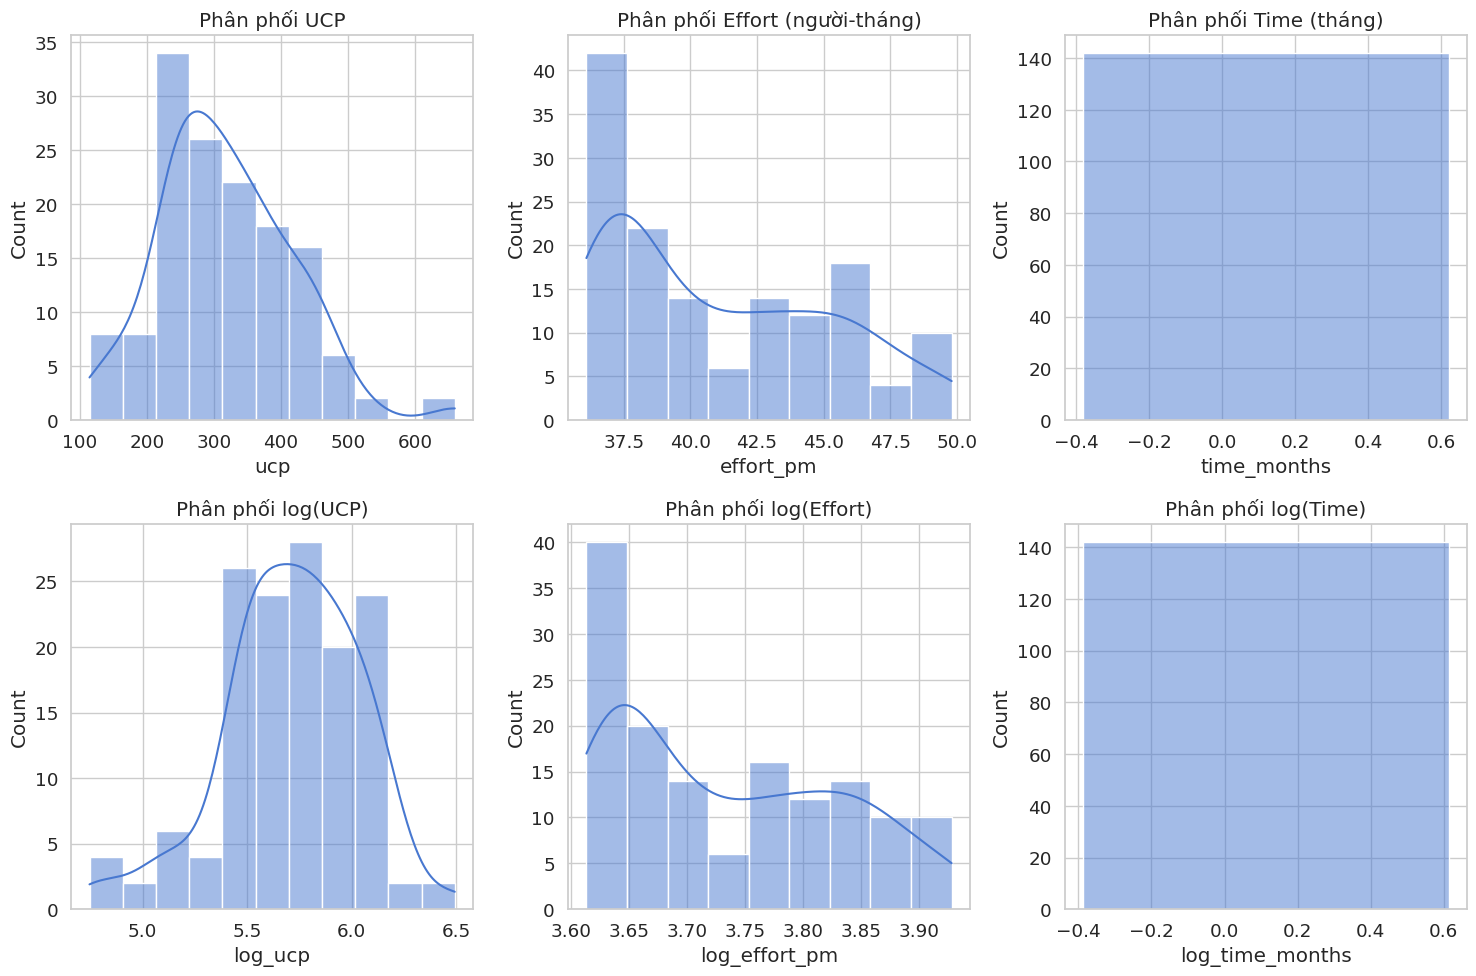

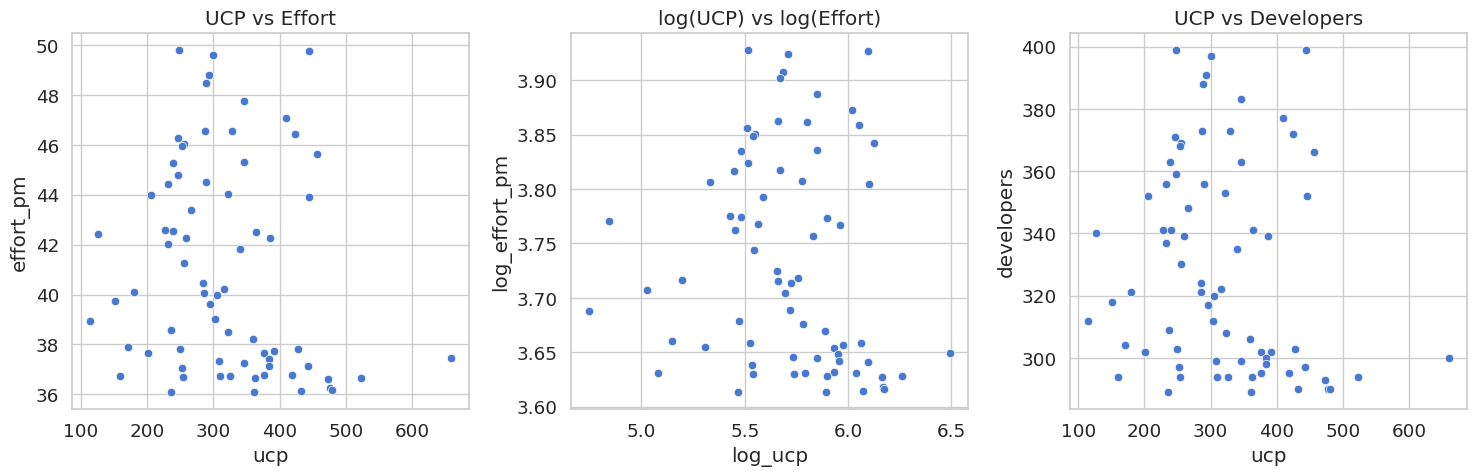

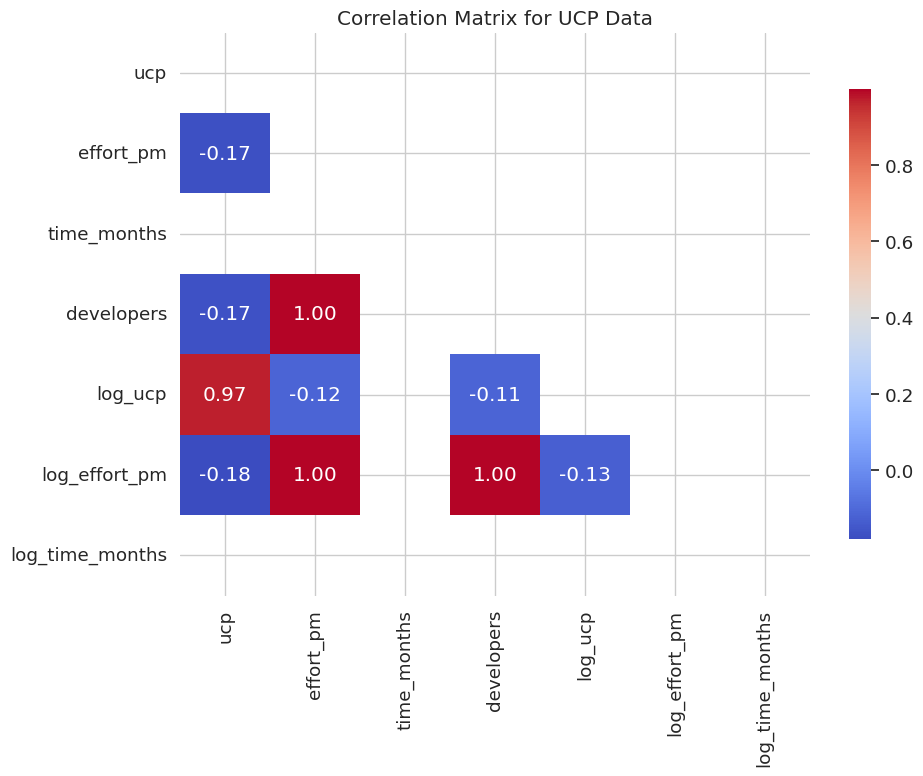

In [37]:
# Biến đổi dữ liệu và trực quan hóa cho schema UCP
if 'ucp_combined_df' in locals() and not ucp_combined_df.empty:
    print("Biến đổi và trực quan hóa dữ liệu UCP:")
    
    # Tạo bản sao để không ảnh hưởng đến dữ liệu gốc
    ucp_transformed = ucp_combined_df.copy()
    
    # Biến đổi logarithmic cho các cột số
    for col in ['ucp', 'effort_pm', 'time_months']:
        if col in ucp_transformed.columns:
            # Thêm 1 để tránh log(0)
            ucp_transformed[f'log_{col}'] = np.log1p(ucp_transformed[col])
    
    # Trực quan hóa phân phối dữ liệu
    plt.figure(figsize=(15, 10))
    
    # Biểu đồ phân phối cho dữ liệu gốc
    plt.subplot(2, 3, 1)
    sns.histplot(ucp_transformed['ucp'], kde=True)
    plt.title('Phân phối UCP')
    
    plt.subplot(2, 3, 2)
    sns.histplot(ucp_transformed['effort_pm'], kde=True)
    plt.title('Phân phối Effort (người-tháng)')
    
    plt.subplot(2, 3, 3)
    sns.histplot(ucp_transformed['time_months'], kde=True)
    plt.title('Phân phối Time (tháng)')
    
    # Biểu đồ phân phối cho dữ liệu đã log transform
    plt.subplot(2, 3, 4)
    sns.histplot(ucp_transformed['log_ucp'], kde=True)
    plt.title('Phân phối log(UCP)')
    
    plt.subplot(2, 3, 5)
    sns.histplot(ucp_transformed['log_effort_pm'], kde=True)
    plt.title('Phân phối log(Effort)')
    
    plt.subplot(2, 3, 6)
    sns.histplot(ucp_transformed['log_time_months'], kde=True)
    plt.title('Phân phối log(Time)')
    
    plt.tight_layout()
    plt.show()
    
    # Biểu đồ scatter để hiển thị mối quan hệ giữa các biến
    plt.figure(figsize=(15, 5))
    
    # UCP vs Effort
    plt.subplot(1, 3, 1)
    sns.scatterplot(x='ucp', y='effort_pm', data=ucp_transformed)
    plt.title('UCP vs Effort')
    
    # log(UCP) vs log(Effort) - Mối quan hệ tuyến tính hơn sau khi log transform
    plt.subplot(1, 3, 2)
    sns.scatterplot(x='log_ucp', y='log_effort_pm', data=ucp_transformed)
    plt.title('log(UCP) vs log(Effort)')
    
    # UCP vs Developers
    plt.subplot(1, 3, 3)
    sns.scatterplot(x='ucp', y='developers', data=ucp_transformed)
    plt.title('UCP vs Developers')
    
    plt.tight_layout()
    plt.show()
    
    # Biểu đồ heatmap thể hiện tương quan giữa các biến
    plt.figure(figsize=(10, 8))
    numeric_cols = ['ucp', 'effort_pm', 'time_months', 'developers', 
                    'log_ucp', 'log_effort_pm', 'log_time_months']
    correlation = ucp_transformed[numeric_cols].corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))
    sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', mask=mask, cbar_kws={'shrink': .8})
    plt.title('Correlation Matrix for UCP Data')
    plt.tight_layout()
    plt.show()
else:
    print("Không có dữ liệu UCP để trực quan hóa!")